# NNDL CA3 Question 1

## Dataset Preperation (from Kaggle)

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("carlolepelaars/camvid")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/camvid


Skipped header: ['name', 'r', 'g', 'b']
Loaded 32 classes from /kaggle/input/camvid/CamVid/class_dict.csv
Searching for images in splits: train, val, test...

Displaying 3 random samples...


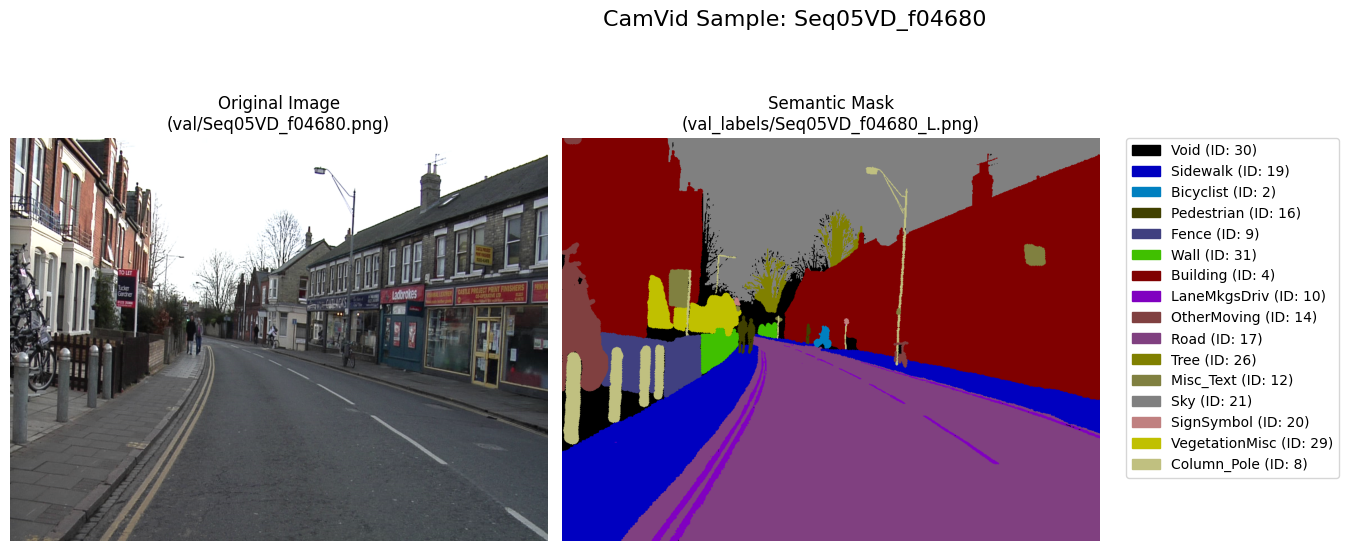

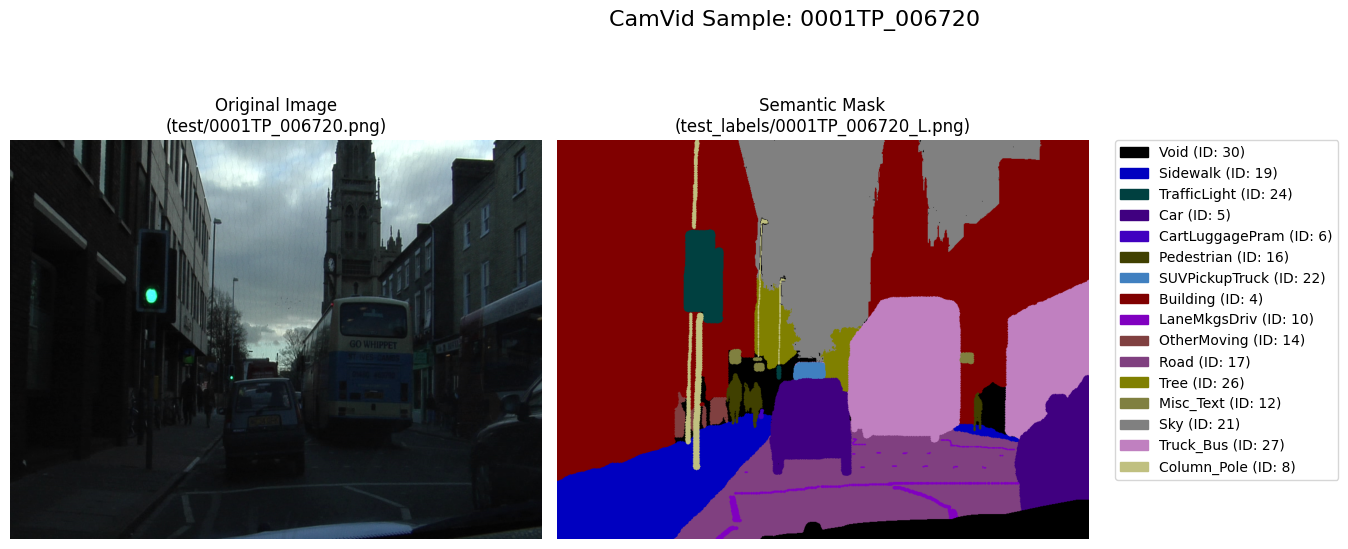

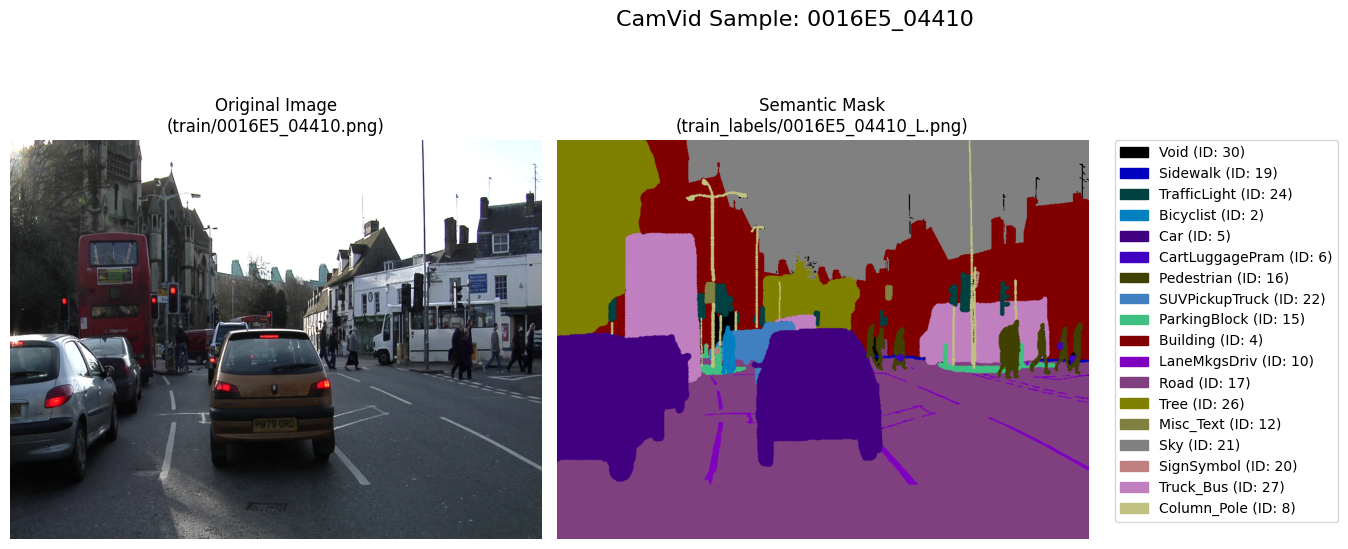

In [5]:
import os
import random
import csv
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

# --- Configuration ---
dataset_base_path = "/kaggle/input/camvid"

# --- Dataset Structure Configuration ---
camvid_subdir = "CamVid"
splits_to_search = ["train", "val", "test"]
image_suffix = ".png"
mask_suffix = "_L.png"
num_samples_to_show = 3

# --- Function to load class info from class_dict.csv ---
def load_class_dict(csv_path):
    """Loads class names and colors from the CamVid class_dict.csv."""
    id_to_name = {}
    id_to_color_normalized = {} # Store normalized (0-1) colors for matplotlib patches
    color_int_to_id = {}      # Store mapping from (R,G,B) tuple (0-255) to ID
    try:
        with open(csv_path, mode='r') as infile:
            reader = csv.reader(infile)
            try:
                header = next(reader)
                print(f"Skipped header: {header}")
            except StopIteration:
                print("Warning: CSV file appears empty or has no header.")
                return None, None, None # Return None if file is empty

            current_id = 0
            for row in reader:
                if len(row) == 4:
                    name = row[0].strip()
                    try:
                        color_int = tuple(int(c) for c in row[1:4])
                        color_normalized = tuple(c/255.0 for c in color_int)

                        id_to_name[current_id] = name
                        id_to_color_normalized[current_id] = color_normalized
                        color_int_to_id[color_int] = current_id 

                        current_id += 1
                    except ValueError:
                        print(f"Warning: Skipping invalid color value in row: {row}")
                else:
                     print(f"Warning: Skipping malformed row in {csv_path}: {row}")

        if not id_to_name:
             print(f"Error: No valid class definitions found in {csv_path} after header.")
             return None, None, None

        print(f"Loaded {len(id_to_name)} classes from {csv_path}")
        return id_to_name, id_to_color_normalized, color_int_to_id

    except FileNotFoundError:
        print(f"Error: Class dictionary file not found at '{csv_path}'. Cannot map class IDs.")
        return None, None, None
    except Exception as e:
        print(f"Error reading class dictionary '{csv_path}': {e}")
        return None, None, None

# --- Main ---
try:
    camvid_dir = os.path.join(dataset_base_path, camvid_subdir)
    if not os.path.isdir(camvid_dir):
        raise FileNotFoundError(f"CamVid directory not found at '{camvid_dir}'. Check 'dataset_base_path' and 'camvid_subdir'.")

    # Load class definitions
    class_dict_path = os.path.join(camvid_dir, "class_dict.csv")
    id_to_name, id_to_color_normalized, color_int_to_id = load_class_dict(class_dict_path)

    if id_to_name is None:
        print("Exiting due to missing class definitions.")
        exit()

    # --- Find all image files ---
    all_image_paths = []
    print(f"Searching for images in splits: {', '.join(splits_to_search)}...")
    for split in splits_to_search:
        image_dir = os.path.join(camvid_dir, split)
        if os.path.isdir(image_dir):
            for filename in os.listdir(image_dir):
                if filename.endswith(image_suffix) and not filename.endswith(mask_suffix):
                    full_path = os.path.join(image_dir, filename)
                    all_image_paths.append(full_path)
        else:
            print(f"Warning: Image directory for split '{split}' not found at '{image_dir}'.")

    if not all_image_paths:
        print(f"Error: No images found in the specified splits within '{camvid_dir}'.")
        exit()

    num_samples = min(num_samples_to_show, len(all_image_paths))
    if num_samples == 0: print("No images available."); exit()
    if num_samples < num_samples_to_show: print(f"Warning: Only found {num_samples} images.")

    random_image_paths = random.sample(all_image_paths, num_samples)
    print(f"\nDisplaying {num_samples} random samples...")

    for img_path in random_image_paths:
        try:
            # --- Derive mask path ---
            img_filename = os.path.basename(img_path)
            img_dir = os.path.dirname(img_path)
            split_name = os.path.basename(img_dir)
            mask_dir_name = f"{split_name}_labels"
            mask_dir = os.path.join(os.path.dirname(img_dir), mask_dir_name)
            base_name = img_filename.replace(image_suffix, '')
            mask_filename = base_name + mask_suffix
            mask_path = os.path.join(mask_dir, mask_filename)

            if not os.path.exists(mask_path):
                print(f"Warning: Mask file '{mask_path}' not found for image '{img_path}'. Skipping.")
                continue

            # --- Load Images --- #
            original_img = Image.open(img_path).convert('RGB')

            mask_img_pil = Image.open(mask_path).convert('RGB')

            mask_display_array = np.array(mask_img_pil)

            # --- Plotting ---
            fig, axes = plt.subplots(1, 2, figsize=(16, 6))

            # Display Original Image
            axes[0].imshow(original_img)
            axes[0].set_title(f"Original Image\n({os.path.join(split_name, img_filename)})")
            axes[0].axis('off')

            # --- Display PRE-COLORED Mask ---
            axes[1].imshow(mask_display_array)
            axes[1].set_title(f"Semantic Mask\n({os.path.join(mask_dir_name, mask_filename)})")
            axes[1].axis('off')

            # --- Create Legend based on colors found in the mask ---
            legend_patches = []
            unique_colors_int = np.unique(mask_display_array.reshape(-1, 3), axis=0)

            for color_int_tuple in map(tuple, unique_colors_int): 
                if color_int_tuple in color_int_to_id:
                    class_id = color_int_to_id[color_int_tuple]
                    name = id_to_name.get(class_id, f"Unknown ID: {class_id}")

                    patch_color = id_to_color_normalized.get(class_id, (0.5, 0.5, 0.5)) 
                    legend_patches.append(mpatches.Patch(color=patch_color, label=f"{name} (ID: {class_id})"))
                else:
                    unknown_patch_color = tuple(c/255.0 for c in color_int_tuple)
                    legend_patches.append(mpatches.Patch(color=unknown_patch_color, label=f"Unknown Color: {color_int_tuple}"))

            if legend_patches:
                axes[1].legend(handles=legend_patches,
                               bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

            plt.suptitle(f"CamVid Sample: {base_name}", fontsize=16, y=1.0)
            plt.tight_layout(rect=[0, 0, 0.85, 1])
            plt.show()

        except FileNotFoundError:
            print(f"Error: Could not find image '{img_path}' or its derived mask path '{mask_path}'.")
        except Exception as e:
            print(f"An error occurred processing {img_path}: {e}")
            try:
                print(f"Debug: Shape of mask_display_array for {img_path} was {mask_display_array.shape}")
            except NameError:
                 print("Debug: mask_display_array was not created.")


except FileNotFoundError as e:
    print(f"Error: {e}")
    print("Please ensure 'dataset_base_path' points to the directory *containing* the 'CamVid' folder,")
    print("and that the 'CamVid' folder and its subdirectories (train, train_labels, etc.) exist.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

In [6]:
import os
import csv
from PIL import Image
import numpy as np
from collections import defaultdict
import time 

# --- Configuration ---
dataset_base_path = "/kaggle/input/camvid" 

# --- Dataset Structure Configuration ---
camvid_subdir = "CamVid"
splits = ["train", "val", "test"] 
image_suffix = ".png"
mask_suffix = "_L.png"

# --- Function to load class info from class_dict.csv ---
def load_class_dict(csv_path):
    """Loads class names and color mappings from the CamVid class_dict.csv."""
    id_to_name = {}
    color_int_to_id = {}
    try:
        with open(csv_path, mode='r') as infile:
            reader = csv.reader(infile)
            try:
                header = next(reader) # Skip header
            except StopIteration:
                print("Warning: CSV file appears empty.")
                return None, None

            current_id = 0
            for row in reader:
                if len(row) == 4:
                    name = row[0].strip()
                    try:
                        color_int = tuple(int(c) for c in row[1:4])
                        id_to_name[current_id] = name
                        color_int_to_id[color_int] = current_id
                        current_id += 1
                    except ValueError:
                        print(f"Warning: Skipping invalid color value in row: {row}")
                else:
                     print(f"Warning: Skipping malformed row in {csv_path}: {row}")

        if not id_to_name:
             print(f"Error: No valid class definitions found in {csv_path}.")
             return None, None

        print(f"Loaded {len(id_to_name)} classes from {csv_path}")
        
        if (0, 0, 0) not in color_int_to_id:
             unlabelled_id = next((id for id, name in id_to_name.items() if 'unlabelled' in name.lower()), len(id_to_name))
             if unlabelled_id == len(id_to_name): # If 'Unlabelled' wasn't found
                 id_to_name[unlabelled_id] = "Background/Unknown"
             color_int_to_id[(0, 0, 0)] = unlabelled_id
             print(f"Added mapping for Black (0,0,0) to ID {unlabelled_id} ('{id_to_name[unlabelled_id]}')")


        return id_to_name, color_int_to_id

    except FileNotFoundError:
        print(f"Error: Class dictionary file not found at '{csv_path}'.")
        return None, None
    except Exception as e:
        print(f"Error reading class dictionary '{csv_path}': {e}")
        return None, None

# --- Statistics Calculation ---
start_time = time.time()
try:
    camvid_dir = os.path.join(dataset_base_path, camvid_subdir)
    if not os.path.isdir(camvid_dir):
        raise FileNotFoundError(f"CamVid directory not found at '{camvid_dir}'.")

    class_dict_path = os.path.join(camvid_dir, "class_dict.csv")
    id_to_name, color_int_to_id = load_class_dict(class_dict_path)

    if id_to_name is None:
        print("Exiting due to missing class definitions.")
        exit()

    # --- Data Structures for Statistics ---
    stats = {}
    overall_pixel_counts = defaultdict(int)
    overall_total_pixels = 0
    image_dimensions = set() 

    print("\nCalculating dataset statistics...")

    for split in splits:
        print(f"\n--- Processing Split: {split} ---")
        split_image_count = 0
        split_pixel_counts = defaultdict(int)
        split_total_pixels = 0
        mask_dir_name = f"{split}_labels"
        mask_dir = os.path.join(camvid_dir, mask_dir_name)

        if not os.path.isdir(mask_dir):
            print(f"Warning: Mask directory '{mask_dir}' not found for split '{split}'. Skipping.")
            stats[split] = {'image_count': 0, 'pixel_counts': {}, 'total_pixels': 0}
            continue

        mask_files = [f for f in os.listdir(mask_dir) if f.endswith(mask_suffix)]
        split_image_count = len(mask_files)
        if split_image_count == 0:
             print(f"No mask files found in '{mask_dir}'.")
             stats[split] = {'image_count': 0, 'pixel_counts': {}, 'total_pixels': 0}
             continue

        print(f"Found {split_image_count} mask files. Analyzing pixels...")
        count = 0
        for mask_filename in mask_files:
            count += 1
            if count % 50 == 0: 
                 print(f"  Processed {count}/{split_image_count} masks in '{split}'...")

            mask_path = os.path.join(mask_dir, mask_filename)
            try:
                mask_img_pil = Image.open(mask_path).convert('RGB')
                mask_array = np.array(mask_img_pil)

                h, w, c = mask_array.shape
                image_dimensions.add((h, w))
                num_pixels_in_mask = h * w
                split_total_pixels += num_pixels_in_mask
                overall_total_pixels += num_pixels_in_mask

                unique_colors, counts = np.unique(mask_array.reshape(-1, 3), axis=0, return_counts=True)

                for color_int_tuple, pixel_count in zip(map(tuple, unique_colors), counts):
                    if color_int_tuple in color_int_to_id:
                        class_id = color_int_to_id[color_int_tuple]
                        split_pixel_counts[class_id] += pixel_count
                        overall_pixel_counts[class_id] += pixel_count
                    else:
                        unknown_id = color_int_to_id.get((0,0,0), -1) 
                        if unknown_id != -1:
                             split_pixel_counts[unknown_id] += pixel_count
                             overall_pixel_counts[unknown_id] += pixel_count
                        else: 
                             print(f"Warning: Color {color_int_tuple} found in {mask_filename} but not in class dict or mapped to black.")


            except Exception as e:
                print(f"Error processing mask file {mask_path}: {e}")

        stats[split] = {
            'image_count': split_image_count,
            'pixel_counts': dict(split_pixel_counts), 
            'total_pixels': split_total_pixels
        }
        print(f"Finished processing {split} split.")

    # --- Display Statistics ---
    print("\n\n--- Dataset Statistics Summary ---")
    print("-" * 30)

    # Image Dimensions
    print("\nImage Dimensions Found (Height, Width):")
    if image_dimensions:
        for dim in sorted(list(image_dimensions)):
            print(f"- {dim[0]} x {dim[1]}")
        if len(image_dimensions) > 1:
            print("Warning: Inconsistent image dimensions found across the dataset.")
    else:
        print("No images processed or dimensions could not be determined.")

    # Per-Split Statistics
    for split in splits:
        print(f"\n--- {split.upper()} Split ---")
        if split in stats and stats[split]['image_count'] > 0:
            data = stats[split]
            print(f"Number of Images: {data['image_count']}")
            print(f"Total Pixels:    {data['total_pixels']:,}")
            print("\nPixel Distribution by Class:")
            sorted_class_ids = sorted(data['pixel_counts'].keys())
            print(f"{'Class Name':<20} {'Class ID':<10} {'Pixel Count':<15} {'Percentage':<10}")
            print("-" * 60)
            for class_id in sorted_class_ids:
                count = data['pixel_counts'][class_id]
                percentage = (count / data['total_pixels']) * 100 if data['total_pixels'] > 0 else 0
                class_name = id_to_name.get(class_id, f"Unknown ID {class_id}")
                print(f"{class_name:<20} {class_id:<10} {count:<15,} {percentage:>9.2f}%")
        else:
            print("No data processed for this split.")

    # Overall Statistics
    print("\n--- OVERALL Dataset ---")
    total_images = sum(stats[split]['image_count'] for split in splits if split in stats)
    print(f"Total Number of Images: {total_images}")
    print(f"Overall Total Pixels:   {overall_total_pixels:,}")
    print("\nOverall Pixel Distribution by Class:")
    sorted_overall_class_ids = sorted(overall_pixel_counts.keys())
    print(f"{'Class Name':<20} {'Class ID':<10} {'Pixel Count':<15} {'Percentage':<10}")
    print("-" * 60)
    for class_id in sorted_overall_class_ids:
        count = overall_pixel_counts[class_id]
        percentage = (count / overall_total_pixels) * 100 if overall_total_pixels > 0 else 0
        class_name = id_to_name.get(class_id, f"Unknown ID {class_id}")
        print(f"{class_name:<20} {class_id:<10} {count:<15,} {percentage:>9.2f}%")

    end_time = time.time()
    print("-" * 30)
    print(f"\nStatistics calculation finished in {end_time - start_time:.2f} seconds.")


except FileNotFoundError as e:
    print(f"Error: {e}")
    print("Please ensure 'dataset_base_path' and 'camvid_subdir' are correct.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Loaded 32 classes from /kaggle/input/camvid/CamVid/class_dict.csv

Calculating dataset statistics...

--- Processing Split: train ---
Found 369 mask files. Analyzing pixels...
  Processed 50/369 masks in 'train'...
  Processed 100/369 masks in 'train'...
  Processed 150/369 masks in 'train'...
  Processed 200/369 masks in 'train'...
  Processed 250/369 masks in 'train'...
  Processed 300/369 masks in 'train'...
  Processed 350/369 masks in 'train'...
Finished processing train split.

--- Processing Split: val ---
Found 100 mask files. Analyzing pixels...
  Processed 50/100 masks in 'val'...
  Processed 100/100 masks in 'val'...
Finished processing val split.

--- Processing Split: test ---
Found 232 mask files. Analyzing pixels...
  Processed 50/232 masks in 'test'...
  Processed 100/232 masks in 'test'...
  Processed 150/232 masks in 'test'...
  Processed 200/232 masks in 'test'...
Finished processing test split.


--- Dataset Statistics Summary ---
------------------------------

Ima

## GPU Configuration

In [1]:
import tensorflow as tf

# list of physical GPU devices visible to TensorFlow
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    print(e)
else:
    print("No GPU detected by TensorFlow.")

2025-05-02 14:08:48.084181: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746194928.255004      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746194928.304797      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


1 Physical GPUs, 1 Logical GPUs


I0000 00:00:1746194939.592115      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


## TPU Configuration

In [1]:
import tensorflow as tf

# Detect and initialize TPU
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu="local")  
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
    print(f"Running on TPU: {tpu.master()}")
except Exception as e:
    print(f"Could not initialize TPU: {e}")
    strategy = tf.distribute.get_strategy()  # Fallback to default CPU/GPU
    print("Running on CPU or single GPU")

# Print number of available TPU cores
print("Number of devices:", strategy.num_replicas_in_sync)

E0000 00:00:1746193681.711419      10 common_lib.cc:612] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: ===
learning/45eac/tfrc/runtime/common_lib.cc:230


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local


I0000 00:00:1746193701.006839      10 service.cc:148] XLA service 0x5928addfa970 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746193701.006881      10 service.cc:156]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1746193701.006886      10 service.cc:156]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1746193701.006889      10 service.cc:156]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1746193701.006893      10 service.cc:156]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1746193701.006896      10 service.cc:156]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1746193701.006899      10 service.cc:156]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1746193701.006901      10 service.cc:156]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1746193701.006904      10 service.cc:156]   StreamExecutor device (7): TPU, 2a886c8


INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)
I

## Fast-SCNN

In [22]:
import tensorflow as tf

class DepthwiseSeparableConv(tf.keras.layers.Layer):
    def __init__(self, out_channels, kernel_size=3, strides=1, activation=True, name=None):
        super().__init__(name=name)

        act_fn = tf.keras.layers.ReLU if activation else tf.keras.layers.Activation('linear')

        self.dwconv = tf.keras.layers.DepthwiseConv2D(
            kernel_size=kernel_size,
            strides=strides,
            padding='same',
            use_bias=False,
            name=f"{name}_dwconv" if name else None
        )
        self.bn1 = tf.keras.layers.BatchNormalization(name=f"{name}_bn1" if name else None)
        self.act1 = act_fn(name=f"{name}_act1" if name else None)

        self.pwconv = tf.keras.layers.Conv2D(
            filters=out_channels,
            kernel_size=1,
            strides=1,
            padding='same',
            use_bias=False,
            name=f"{name}_pwconv" if name else None
        )
        self.bn2 = tf.keras.layers.BatchNormalization(name=f"{name}_bn2" if name else None)
        # Activation after pointwise conv (standard DSConv structure)
        self.act2 = act_fn(name=f"{name}_act2" if name else None)

    def call(self, inputs, training=False):
        x = self.dwconv(inputs)
        x = self.bn1(x, training=training)
        x = self.act1(x)
        x = self.pwconv(x)
        x = self.bn2(x, training=training)
        x = self.act2(x)
        return x

class InvertedResidual(tf.keras.layers.Layer):
    def __init__(self, out_channels, expansion, strides=1, name=None):
        super().__init__(name=name)
        self.strides = strides
        self.out_channels = out_channels
        self.expansion = expansion
        # Layer definitions moved to build for clarity, though not strictly necessary as Keras layers handle deferred building.
        self.expand_conv = None
        self.bn0 = None
        self.act0 = None
        self.dwconv = None
        self.bn1 = None
        self.act1 = None
        self.project_conv = None
        self.bn2 = None
        self.use_res_connect = False
        self._in_channels = None # Store input channels

    def build(self, input_shape):
        self._in_channels = input_shape[-1]
        # Expansion phase
        expanded_channels = self._in_channels * self.expansion
        if self.expansion != 1:
            self.expand_conv = tf.keras.layers.Conv2D(
                filters=expanded_channels,
                kernel_size=1,
                padding='same',
                use_bias=False,
                name=f"{self.name}_expand_conv" if self.name else None
            )
            self.bn0 = tf.keras.layers.BatchNormalization(name=f"{self.name}_bn0" if self.name else None)
            self.act0 = tf.keras.layers.ReLU(name=f"{self.name}_act0" if self.name else None)

        # Depthwise conv
        self.dwconv = tf.keras.layers.DepthwiseConv2D(
            kernel_size=3,
            strides=self.strides,
            padding='same',
            use_bias=False,
            name=f"{self.name}_dwconv" if self.name else None
        )
        self.bn1 = tf.keras.layers.BatchNormalization(name=f"{self.name}_bn1" if self.name else None)
        self.act1 = tf.keras.layers.ReLU(name=f"{self.name}_act1" if self.name else None)

        # Projection (linear) - No activation after projection BN
        self.project_conv = tf.keras.layers.Conv2D(
            filters=self.out_channels,
            kernel_size=1,
            padding='same',
            use_bias=False,
            name=f"{self.name}_project_conv" if self.name else None
        )
        self.bn2 = tf.keras.layers.BatchNormalization(name=f"{self.name}_bn2" if self.name else None)

        self.use_res_connect = (self.strides == 1 and self._in_channels == self.out_channels)
        super().build(input_shape) # Call parent build method

    def call(self, inputs, training=False):
        x = inputs
        # Expansion
        if self.expansion != 1:
            x = self.expand_conv(x)
            x = self.bn0(x, training=training)
            x = self.act0(x)
        # Depthwise
        x = self.dwconv(x)
        x = self.bn1(x, training=training)
        x = self.act1(x)
        # Projection
        x = self.project_conv(x)
        x = self.bn2(x, training=training) 

        # Residual connection
        if self.use_res_connect:
            return tf.keras.layers.Add(name=f"{self.name}_add" if self.name else None)([inputs, x])
        return x

class PyramidPoolingModule(tf.keras.layers.Layer):
    def __init__(self, pool_sizes=(1, 2, 3, 6), name=None):
        super().__init__(name=name)
        self.pool_sizes = pool_sizes
        self.conv_layers = []

    def build(self, input_shape):
        num_input_channels = input_shape[-1]
        num_filters_per_pool = num_input_channels // len(self.pool_sizes)
        if num_input_channels % len(self.pool_sizes) != 0:
             print(f"Warning: PPM input channels ({num_input_channels}) not perfectly divisible by number of pool sizes ({len(self.pool_sizes)}). Adjusting filters per pool.")

        self.conv_layers = [] 
        for i, size in enumerate(self.pool_sizes):
            pool_name = f"{self.name}_pool{i+1}" if self.name else f"ppm_pool{i+1}"
            # Define layers within build
            pooling_layer = (
                tf.keras.layers.GlobalAveragePooling2D(keepdims=True) if size == 1 else
                tf.keras.layers.AveragePooling2D(pool_size=(size, size), strides=(size, size), padding='valid') # Use 'valid' padding for pooling
            )
            conv_layer = tf.keras.layers.Conv2D(filters=num_filters_per_pool, kernel_size=1, padding='same', use_bias=False)
            bn_layer = tf.keras.layers.BatchNormalization()
            relu_layer = tf.keras.layers.ReLU()

            self.conv_layers.append(
                tf.keras.Sequential([
                    pooling_layer,
                    conv_layer,
                    bn_layer,
                    relu_layer
                ], name=pool_name)
            )
        super().build(input_shape) 

    def call(self, inputs, training=False):
        h, w = tf.shape(inputs)[1], tf.shape(inputs)[2]
        pooled = [inputs] 
        for layer in self.conv_layers:
            x = layer(inputs, training=training)
            x = tf.image.resize(x, size=(h, w), method='bilinear')
            pooled.append(x)
        return tf.concat(pooled, axis=-1, name=f"{self.name}_concat" if self.name else None)

class FeatureFusionModule(tf.keras.layers.Layer):
    def __init__(self, out_channels, name=None):
        super().__init__(name=name)
        self.out_channels = out_channels
        self.dwconv = DepthwiseSeparableConv(out_channels, kernel_size=3, name=f"{name}_ffm_dwconv" if name else None)
        self.conv_low = tf.keras.layers.Conv2D(out_channels, 1, padding='same', use_bias=False, name=f"{name}_conv_low" if name else None)
        self.bn_low = tf.keras.layers.BatchNormalization(name=f"{name}_bn_low" if name else None)
        self.conv_high = tf.keras.layers.Conv2D(out_channels, 1, padding='same', use_bias=False, name=f"{name}_conv_high" if name else None)
        self.bn_high = tf.keras.layers.BatchNormalization(name=f"{name}_bn_high" if name else None)
        self.add_layer = tf.keras.layers.Add(name=f"{name}_add" if name else None)
        self.act_add = tf.keras.layers.ReLU(name=f"{name}_add_relu" if name else None)


    def call(self, high_res, low_res, training=False):
        # Process low-resolution branch
        low = tf.image.resize(low_res, size=tf.shape(high_res)[1:3], method='bilinear')
        low = self.conv_low(low)
        low = self.bn_low(low, training=training)

        high = self.conv_high(high_res)
        high = self.bn_high(high, training=training)

        x = self.add_layer([high, low])
        x = self.act_add(x) 

        x = self.dwconv(x, training=training)
        return x

# --- Fast-SCNN Model ---

class FastSCNN(tf.keras.Model):
    def __init__(self, num_classes=19, name="FastSCNN", **kwargs):
        super().__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self._input_shape = None # Store input shape

        # === 1. Learning to Downsample ===
        self.conv1 = tf.keras.layers.Conv2D(32, 3, strides=2, padding='same', use_bias=False, name="LTD_Conv1")
        self.bn1 = tf.keras.layers.BatchNormalization(name="LTD_BN1")
        self.act1 = tf.keras.layers.ReLU(name="LTD_Act1")
        self.dsconv2 = DepthwiseSeparableConv(48, strides=2, name="LTD_DSConv2")
        self.dsconv3 = DepthwiseSeparableConv(64, strides=2, name="LTD_DSConv3")

        # === 2. Global Feature Extractor ===
        self.gfe_stage1 = self._make_gfe_stage(out_channels=64, expansion=6, n=3, s=2, stage_num=1)
        self.gfe_stage2 = self._make_gfe_stage(out_channels=96, expansion=6, n=3, s=2, stage_num=2)
        self.gfe_stage3 = self._make_gfe_stage(out_channels=128, expansion=6, n=3, s=1, stage_num=3)
        self.ppm = PyramidPoolingModule(pool_sizes=(1, 2, 3, 6), name="GFE_PPM")
        self.conv_after_ppm = tf.keras.layers.Conv2D(128, 1, padding='same', use_bias=False, name="GFE_PostPPM_Conv")
        self.bn_ppm = tf.keras.layers.BatchNormalization(name="GFE_PostPPM_BN")
        self.act_ppm = tf.keras.layers.ReLU(name="GFE_PostPPM_Act")

        # === 3. Feature Fusion Module ===
        self.ffm = FeatureFusionModule(128, name="FFM")

        # === 4. Classifier ===
        self.classifier_dsconv1 = DepthwiseSeparableConv(128, strides=1, name="CLS_DSConv1")
        self.classifier_dsconv2 = DepthwiseSeparableConv(128, strides=1, name="CLS_DSConv2")
        self.dropout = tf.keras.layers.Dropout(0.2, name="CLS_Dropout")
        self.conv_last = tf.keras.layers.Conv2D(self.num_classes, 1, padding='same', name="CLS_ConvLast")

    def _make_gfe_stage(self, out_channels, expansion, n, s, stage_num):
        stage_name = f"GFE_Stage{stage_num}"
        blocks = tf.keras.Sequential(name=stage_name)
        blocks.add(InvertedResidual(out_channels, expansion, strides=s, name=f"{stage_name}_Block1"))
        for i in range(1, n):
            blocks.add(InvertedResidual(out_channels, expansion, strides=1, name=f"{stage_name}_Block{i+1}"))
        return blocks

    def build(self, input_shape):
        self._input_shape = input_shape
        super().build(input_shape)

        self.built = True
        print(f"FastSCNN model built with input shape: {input_shape}")


    def call(self, inputs, training=False):
        # === 1. Learning to Downsample ===
        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = self.act1(x)
        x = self.dsconv2(x, training=training)
        high_res_features = self.dsconv3(x, training=training) # H/8

        # === 2. Global Feature Extractor ===
        x = self.gfe_stage1(high_res_features, training=training)
        x = self.gfe_stage2(x, training=training)
        x = self.gfe_stage3(x, training=training)
        x = self.ppm(x, training=training)
        x = self.conv_after_ppm(x)
        x = self.bn_ppm(x, training=training)
        low_res_features = self.act_ppm(x) # H/32

        # === 3. Feature Fusion ===
        x = self.ffm(high_res_features, low_res_features, training=training) # Output is H/8

        # === 4. Classifier ===
        x = self.classifier_dsconv1(x, training=training)
        x = self.classifier_dsconv2(x, training=training)
        x = self.dropout(x, training=training) # Apply dropout before final conv
        x = self.conv_last(x) # H/8 x W/8 x num_classes

        # === Final Upsampling ===
        # Upsample output to the original input size
        output = tf.image.resize(x, size=tf.shape(inputs)[1:3], method='bilinear', name="Final_Upsample")

        return output

if __name__ == '__main__':
    IMG_H, IMG_W = 720, 960 # CamVid size
    NUM_CLS = 32 # CamVid classes

    model = FastSCNN(num_classes=NUM_CLS)

    sample_input = tf.keras.Input(shape=(IMG_H, IMG_W, 3))
    _ = model(sample_input) # build model via call
    model.summary()


    try:
        tf.keras.utils.plot_model(
            model, to_file='fast_scnn_architecture.png', show_shapes=True, show_dtype=False,
            show_layer_names=True, rankdir='TB', show_layer_activations=True
        )
        print("Model architecture plot saved to fast_scnn_architecture.png")
    except ImportError as e:
        print(f"Could not plot model architecture: {e}. Please install pydot and graphviz.")


    trainable_count = tf.reduce_sum([tf.size(v) for v in model.trainable_variables])
    non_trainable_count = tf.reduce_sum([tf.size(v) for v in model.non_trainable_variables])
    print(f"Trainable parameters: {trainable_count.numpy():,}")
    print(f"Non-trainable parameters: {non_trainable_count.numpy():,}")

FastSCNN model built with input shape: (None, 720, 960, 3)


Model: "FastSCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ LTD_Conv1 (Conv2D)                   │ (None, 360, 480, 32)        │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ LTD_BN1 (BatchNormalization)         │ (None, 360, 480, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ LTD_Act1 (ReLU)                      │ (None, 360, 480, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ LTD_DSConv2 (DepthwiseSeparableConv) │ ?                           │           2,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ LTD_DSConv3 (DepthwiseSeparableConv) │ ?                           │           3,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ GFE_Stage1 (Sequential)              │ (None, 45, 60, 64)          │         167,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ GFE_Stage2 (Sequential)              │ (None, 23, 30, 96)          │         309,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ GFE_Stage3 (Sequential)              │ (None, 23, 30, 128)         │         559,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ GFE_PPM (PyramidPoolingModule)       │ ?                           │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ GFE_PostPPM_Conv (Conv2D)            │ (None, 23, 30, 128)         │          32,768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ GFE_PostPPM_BN (BatchNormalization)  │ (None, 23, 30, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ GFE_PostPPM_Act (ReLU)               │ (None, 23, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ FFM (FeatureFusionModule)            │ ?                           │          44,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ CLS_DSConv1 (DepthwiseSeparableConv) │ ?                           │          18,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ CLS_DSConv2 (DepthwiseSeparableConv) │ ?                           │          18,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ CLS_Dropout (Dropout)                │ (None, 90, 120, 128)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ CLS_ConvLast (Conv2D)                │ (None, 90, 120, 32)         │           4,128 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,180,048 (4.50 MB)

 Trainable params: 1,156,112 (4.41 MB)

 Non-trainable params: 23,936 (93.50 KB)

Model architecture plot saved to fast_scnn_architecture.png
Trainable parameters: 1,156,112
Non-trainable parameters: 23,938


## IoU Score & Dice Coefficient

In [20]:
import tensorflow as tf
import numpy as np 


class MeanIoU(tf.keras.metrics.Metric):
    def __init__(self, num_classes, ignore_class=None, name='mean_iou', dtype=None, smooth=1e-6):
        super(MeanIoU, self).__init__(name=name, dtype=dtype)
        self.num_classes = num_classes
        self.ignore_class = ignore_class
        self.smooth = smooth

        self.total_intersection = self.add_weight(
            name='total_intersection', 
            shape=(num_classes,),      
            initializer=tf.zeros_initializer
        )
        self.total_union = self.add_weight(
            name='total_union',       
            shape=(num_classes,),     
            initializer=tf.zeros_initializer
        )

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, self._dtype)
        y_pred_classes = tf.argmax(y_pred, axis=-1, output_type=tf.dtypes.int32)
        y_pred_classes = tf.cast(y_pred_classes, self._dtype)

        y_true_flat = tf.reshape(y_true, [-1])
        y_pred_flat = tf.reshape(y_pred_classes, [-1])


        y_true_one_hot = tf.one_hot(tf.cast(y_true_flat, tf.int32), depth=self.num_classes, dtype=self._dtype)
        y_pred_one_hot = tf.one_hot(tf.cast(y_pred_flat, tf.int32), depth=self.num_classes, dtype=self._dtype)

        intersection = tf.reduce_sum(y_true_one_hot * y_pred_one_hot, axis=0)
        union = tf.reduce_sum(y_true_one_hot + y_pred_one_hot, axis=0) - intersection

        self.total_intersection.assign_add(intersection)
        self.total_union.assign_add(union)

    def result(self):
        iou_per_class = tf.math.divide_no_nan(
            self.total_intersection + self.smooth,
            self.total_union + self.smooth
        )

        if self.ignore_class is not None:
            valid_classes_mask = tf.cast(
                tf.range(self.num_classes) != self.ignore_class,
                dtype=self._dtype
            )
            iou_per_class *= valid_classes_mask
            num_valid_classes = tf.reduce_sum(valid_classes_mask)
        else:
            num_valid_classes = tf.cast(self.num_classes, dtype=self._dtype)

        mean_iou = tf.math.divide_no_nan(
            tf.reduce_sum(iou_per_class),
            num_valid_classes
        )
        return mean_iou

    def reset_state(self):
        for v in self.variables:
            v.assign(tf.zeros(shape=v.shape, dtype=v.dtype))

    def get_config(self):
        config = super(MeanIoU, self).get_config()
        config.update({
            "num_classes": self.num_classes,
            "ignore_class": self.ignore_class,
            "smooth": self.smooth,
        })
        return config


class DiceCoefficient(tf.keras.metrics.Metric):
    def __init__(self, num_classes, ignore_class=None, name='dice_coefficient', dtype=None, smooth=1e-6):
        super(DiceCoefficient, self).__init__(name=name, dtype=dtype)
        self.num_classes = num_classes
        self.ignore_class = ignore_class
        self.smooth = smooth

        self.total_intersection = self.add_weight(
            name='total_intersection', # Explicitly name='...'
            shape=(num_classes,),      # Explicitly shape=...
            initializer=tf.zeros_initializer
        )
        self.total_sum_areas = self.add_weight(
            name='total_sum_areas',    # Explicitly name='...'
            shape=(num_classes,),      # Explicitly shape=...
            initializer=tf.zeros_initializer
        )

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, self._dtype)
        y_pred_classes = tf.argmax(y_pred, axis=-1, output_type=tf.dtypes.int32)
        y_pred_classes = tf.cast(y_pred_classes, self._dtype)

        y_true_flat = tf.reshape(y_true, [-1])
        y_pred_flat = tf.reshape(y_pred_classes, [-1])

        y_true_one_hot = tf.one_hot(tf.cast(y_true_flat, tf.int32), depth=self.num_classes, dtype=self._dtype)
        y_pred_one_hot = tf.one_hot(tf.cast(y_pred_flat, tf.int32), depth=self.num_classes, dtype=self._dtype)

        intersection = tf.reduce_sum(y_true_one_hot * y_pred_one_hot, axis=0)
        sum_areas = tf.reduce_sum(y_true_one_hot, axis=0) + tf.reduce_sum(y_pred_one_hot, axis=0)

        self.total_intersection.assign_add(intersection)
        self.total_sum_areas.assign_add(sum_areas)

    def result(self):
        dice_per_class = tf.math.divide_no_nan(
            (2. * self.total_intersection) + self.smooth,
            self.total_sum_areas + self.smooth
        )

        if self.ignore_class is not None:
            valid_classes_mask = tf.cast(
                tf.range(self.num_classes) != self.ignore_class,
                dtype=self._dtype
            )
            dice_per_class *= valid_classes_mask
            num_valid_classes = tf.reduce_sum(valid_classes_mask)
        else:
            num_valid_classes = tf.cast(self.num_classes, dtype=self._dtype)

        mean_dice = tf.math.divide_no_nan(
            tf.reduce_sum(dice_per_class),
            num_valid_classes
        )
        return mean_dice

    def reset_state(self):
        for v in self.variables:
            v.assign(tf.zeros(shape=v.shape, dtype=v.dtype))

    def get_config(self):
        config = super(DiceCoefficient, self).get_config()
        config.update({
            "num_classes": self.num_classes,
            "ignore_class": self.ignore_class,
            "smooth": self.smooth,
        })
        return config

## Training & Validation of Fast-SCNN

--- Starting Fast-SCNN Training on CamVid ---
TensorFlow Version: 2.18.0
Image Dimensions: 720x960
Number of Classes: 32
Batch Size: 16
Epochs: 200
Class dict header: ['name', 'r', 'g', 'b']
Loaded 32 class color mappings from /kaggle/input/camvid/CamVid/class_dict.csv

Creating TensorFlow datasets...
Found 369 image/mask pairs for split 'train'.

Building Fast-SCNN model...
FastSCNN model built with input shape: (None, 720, 960, 3)


Model: "FastSCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ LTD_Conv1 (Conv2D)                   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ LTD_BN1 (BatchNormalization)         │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ LTD_Act1 (ReLU)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ LTD_DSConv2 (DepthwiseSeparableConv) │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ LTD_DSConv3 (DepthwiseSeparableConv) │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ GFE_Stage1 (Sequential)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ GFE_Stage2 (Sequential)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ GFE_Stage3 (Sequential)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ GFE_PPM (PyramidPoolingModule)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ GFE_PostPPM_Conv (Conv2D)            │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ GFE_PostPPM_BN (BatchNormalization)  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ GFE_PostPPM_Act (ReLU)               │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ FFM (FeatureFusionModule)            │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ CLS_DSConv1 (DepthwiseSeparableConv) │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ CLS_DSConv2 (DepthwiseSeparableConv) │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ CLS_Dropout (Dropout)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ CLS_ConvLast (Conv2D)                │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


Defining metrics...

Compiling model...
Model compiled.

Setting up callbacks...

--- Starting Training ---
Epoch 1/200


W0000 00:00:1746204462.144657      90 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4550 - dice_coefficient: 0.0737 - loss: 2.3048 - mean_iou: 0.0529   
Epoch 1: val_mean_iou improved from -inf to 0.07380, saving model to ./fast_scnn_checkpoints/best_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.4602 - dice_coefficient: 0.0746 - loss: 2.2832 - mean_iou: 0.0536 - val_accuracy: 0.2878 - val_dice_coefficient: 0.0789 - val_loss: 3.2617 - val_mean_iou: 0.0738 - learning_rate: 0.0010
Epoch 2/200
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step - accuracy: 0.7323 - dice_coefficient: 0.2038 - loss: 1.0342 - mean_iou: 0.1799
Epoch 2: val_mean_iou did not improve from 0.07380
24/24 ━━━━━━━━━━━━━━━━━━━━ 12s 519ms/step - accuracy: 0.7336 - dice_coefficient: 0.2013 - loss: 1.0290 - mean_iou: 0.1772 - val_accuracy: 0.2878 - val_dice_coefficient: 0.0789 - val_loss: 3.0811 - val_mean_iou: 0.0738 - learning_rate: 0.0010
Epoch 3/200
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step - accuracy: 0.7840 - dice_coefficient: 0.2369 - los

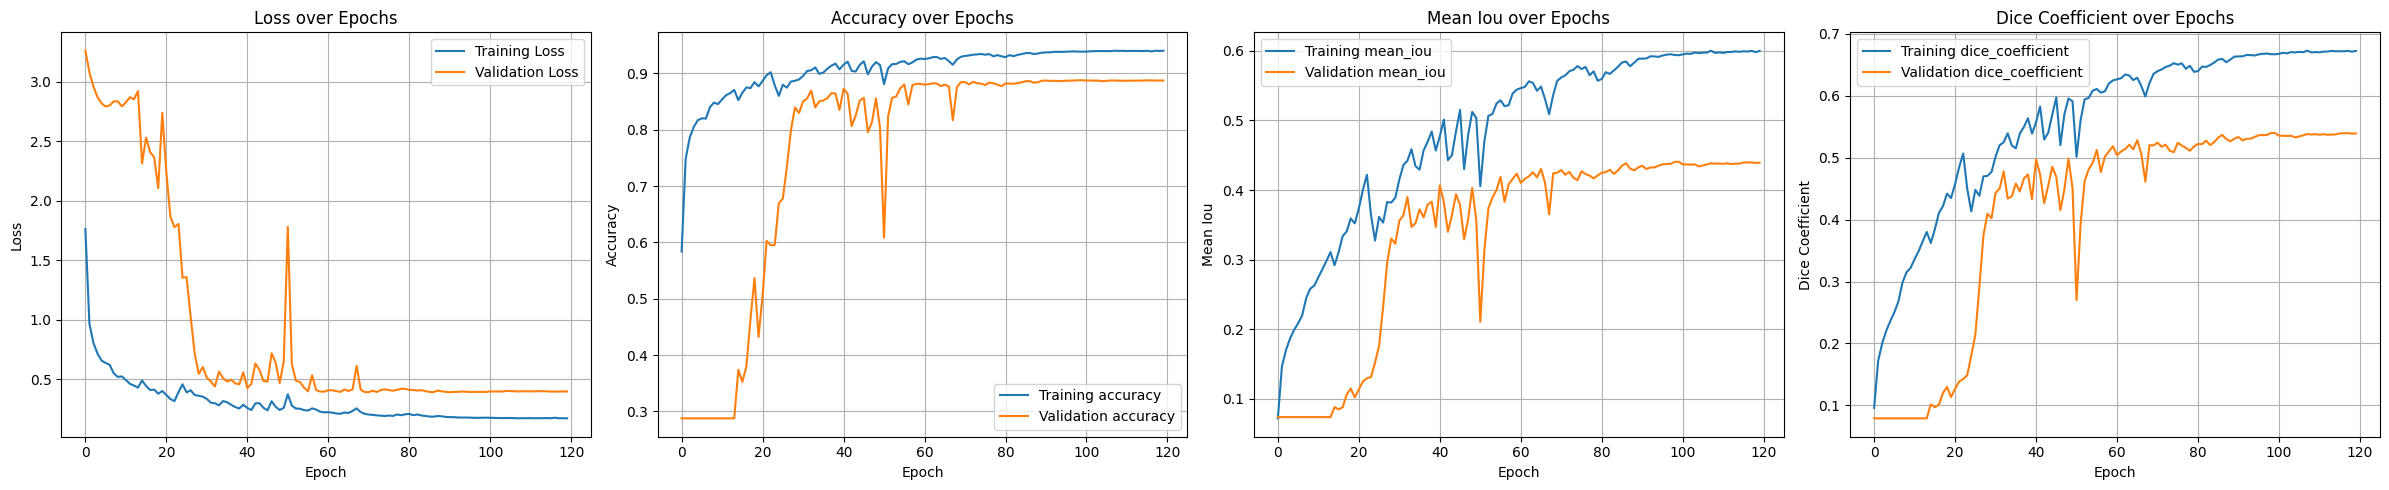


--- Finished ---


In [29]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import time
import csv 
from collections import defaultdict 

# === Configuration ===
DATASET_BASE_PATH = "/kaggle/input/camvid" 
CAMVID_SUBDIR = "CamVid"
CLASS_DICT_FILENAME = "class_dict.csv"

# --- Model & Training Hyperparameters ---
IMG_HEIGHT = 720  # Target image height 
IMG_WIDTH = 960   # Target image width
NUM_CLASSES = 32  # From class_dict.csv
IGNORE_CLASS_ID = 30 # ID for 'Unlabelled' or background (Void)

EPOCHS = 200 # Number of training epochs 
BATCH_SIZE = 16 
BUFFER_SIZE = 400 
LEARNING_RATE = 1e-3 # Initial learning rate

# --- Checkpoint & Output ---
CHECKPOINT_DIR = "./fast_scnn_checkpoints"
CHECKPOINT_FILENAME = "best_model.keras" 
PLOT_FILENAME = "training_history.png"


color_int_to_id_map = {} # Global map for RGB to ID conversion
id_to_name_map = {}      # Global map for ID to Name

def load_class_dict_for_mapping(csv_path):
    global color_int_to_id_map, id_to_name_map
    color_int_to_id_map = {}
    id_to_name_map = {}
    required_ids = set(range(NUM_CLASSES)) 
    found_ids = set()

    try:
        with open(csv_path, mode='r') as infile:
            reader = csv.reader(infile)
            try:
                header = next(reader) # Skip header
                print(f"Class dict header: {header}")
            except StopIteration:
                print("Warning: Class dictionary CSV file appears empty.")
                return False

            current_id = 0
            for row in reader:
                if len(row) == 4:
                    name = row[0].strip()
                    try:
                        color_int = tuple(int(c) for c in row[1:4])
                        if current_id >= NUM_CLASSES:
                             print(f"Warning: Found more classes ({current_id+1}) than expected ({NUM_CLASSES}). Ignoring extra class: {name}")
                             continue

                        if color_int in color_int_to_id_map:
                            print(f"Warning: Duplicate color {color_int} found in class dict for ID {current_id} ('{name}') and ID {color_int_to_id_map[color_int]}. Using first occurrence.")
                        else:
                            color_int_to_id_map[color_int] = current_id
                            id_to_name_map[current_id] = name
                            found_ids.add(current_id)
                        current_id += 1
                    except ValueError:
                        print(f"Warning: Skipping invalid color value in row: {row}")
                else:
                     print(f"Warning: Skipping malformed row in {csv_path}: {row}")

        if not color_int_to_id_map:
             print(f"Error: No valid class definitions found in {csv_path}.")
             return False

        # Check if all expected class IDs were found
        missing_ids = required_ids - found_ids
        if missing_ids:
            print(f"Warning: Expected {NUM_CLASSES} classes, but definitions missing for IDs: {sorted(list(missing_ids))}")

        print(f"Loaded {len(color_int_to_id_map)} class color mappings from {csv_path}")

        if IGNORE_CLASS_ID is not None and IGNORE_CLASS_ID not in id_to_name_map:
             print(f"Warning: Specified IGNORE_CLASS_ID ({IGNORE_CLASS_ID}) not found in the loaded class dictionary.")

        return True

    except FileNotFoundError:
        print(f"Error: Class dictionary file not found at '{csv_path}'. Cannot map colors to IDs.")
        return False
    except Exception as e:
        print(f"Error reading class dictionary '{csv_path}': {e}")
        return False

# Function to convert RGB mask to ID mask using the global map
def rgb_to_id_mask_py(rgb_mask_np):
    id_mask = np.zeros((rgb_mask_np.shape[0], rgb_mask_np.shape[1]), dtype=np.int32)
    # Default to ignore_class_id or a specific value (e.g., 0) if color not found
    default_id = IGNORE_CLASS_ID if IGNORE_CLASS_ID is not None else 0 # Fallback to 0 if ignore_id is None

    for color_tuple, class_id in color_int_to_id_map.items():
        matches = np.all(rgb_mask_np == color_tuple, axis=-1)
        id_mask[matches] = class_id
    return id_mask[:, :, np.newaxis] # Add channel dim back for consistency

@tf.function
def rgb_to_id_mask_tf(rgb_mask):
    id_mask = tf.py_function(
        func=rgb_to_id_mask_py,
        inp=[rgb_mask],
        Tout=tf.int32
    )
    id_mask.set_shape([None, None, 1])
    return id_mask



@tf.function
def load_image_and_mask(image_path, mask_path):
    # Load Image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH], method='bilinear')
    image = tf.cast(image, tf.float32) / 255.0 # Normalize image

    # Load Mask
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.image.resize(mask, [IMG_HEIGHT, IMG_WIDTH], method='nearest')
    mask = tf.cast(mask, tf.uint8) 

    # Convert RGB mask to ID mask
    mask_id = rgb_to_id_mask_tf(mask) 
    mask_id = tf.squeeze(mask_id, axis=-1) 

    return image, mask_id


def create_tf_dataset_for_split(split_name, batch_size, shuffle=False):
    camvid_dir = os.path.join(DATASET_BASE_PATH, CAMVID_SUBDIR)
    image_dir = os.path.join(camvid_dir, split_name)
    mask_dir = os.path.join(camvid_dir, f"{split_name}_labels")

    if not os.path.isdir(image_dir) or not os.path.isdir(mask_dir):
         print(f"Warning: Directory missing for split '{split_name}'. Searched: {image_dir}, {mask_dir}")
         return None

    image_files = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.png')])
    mask_files = []
    valid_image_files = []

    for img_path in image_files:
        img_filename = os.path.basename(img_path)
        base_name = img_filename.replace('.png', '')
        mask_filename = base_name + "_L.png"
        mask_path = os.path.join(mask_dir, mask_filename)
        if os.path.exists(mask_path):
            mask_files.append(mask_path)
            valid_image_files.append(img_path)

    if not valid_image_files:
        print(f"Warning: No valid image/mask pairs found for split '{split_name}'.")
        return None

    print(f"Found {len(valid_image_files)} image/mask pairs for split '{split_name}'.")

    dataset = tf.data.Dataset.from_tensor_slices((valid_image_files, mask_files))
    dataset = dataset.map(load_image_and_mask, num_parallel_calls=tf.data.AUTOTUNE)

    # Cache after mapping
    # dataset = dataset.cache()

    # Augmentation (Applied only to training set)
    if split_name == 'train':
        @tf.function #potential performance improvement
        def augment(image, mask):
            # 1. Random Horizontal Flip (50% chance)
            if tf.random.uniform(()) > 0.5:
                image = tf.image.flip_left_right(image)
                mask = tf.image.flip_left_right(mask)

            # 2. Random Brightness Adjustment
            image = tf.image.random_brightness(image, max_delta=0.1)

            # 3. Random Contrast Adjustment
            image = tf.image.random_contrast(image, lower=0.8, upper=1.2)

            # 4. Random Saturation Adjustment (Requires HSV conversion)
            image = tf.image.random_saturation(image, lower=0.8, upper=1.2)

            # --- Clipping ---
            image = tf.clip_by_value(image, 0.0, 1.0)

            return image, mask

        # Apply the augmentation
        dataset = dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)

    if shuffle:
        buffer_size = min(len(valid_image_files), BUFFER_SIZE)
        dataset = dataset.shuffle(buffer_size)

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

    return dataset


def plot_history(history, metrics_to_plot, filename="training_history.png"):
    num_metrics = len(metrics_to_plot)
    plt.figure(figsize=(6 * (num_metrics + 1), 5)) 

    # Plot Loss
    plt.subplot(1, num_metrics + 1, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot Metrics
    for i, metric in enumerate(metrics_to_plot):
        plt.subplot(1, num_metrics + 1, i + 2)
        plt.plot(history.history[metric], label=f'Training {metric}')
        plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
        plt.title(f'{metric.replace("_", " ").title()} over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel(metric.replace("_", " ").title())
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.savefig(filename)
    print(f"Training history plot saved to {filename}")
    plt.show() 


if __name__ == "__main__":
    print("--- Starting Fast-SCNN Training on CamVid ---")
    print(f"TensorFlow Version: {tf.__version__}")
    print(f"Image Dimensions: {IMG_HEIGHT}x{IMG_WIDTH}")
    print(f"Number of Classes: {NUM_CLASSES}")
    print(f"Batch Size: {BATCH_SIZE}")
    print(f"Epochs: {EPOCHS}")

    # Load Class Dictionary for Color Mapping 
    camvid_dir = os.path.join(DATASET_BASE_PATH, CAMVID_SUBDIR)
    class_dict_path = os.path.join(camvid_dir, CLASS_DICT_FILENAME)
    if not load_class_dict_for_mapping(class_dict_path):
        exit("Failed to load class dictionary. Exiting.")
    if not color_int_to_id_map:
         exit("Color map is empty after loading dictionary. Exiting.")

    # Create Datasets
    print("\nCreating TensorFlow datasets...")
    try:
        train_dataset = create_tf_dataset_for_split('train', BATCH_SIZE, True)
        val_dataset = create_tf_dataset_for_split('val', BATCH_SIZE, False)
        print("Datasets created successfully.")
    except Exception as e:
        exit(f"Error creating datasets: {e}")

    # Build the Model
    print("\nBuilding Fast-SCNN model...")
    model = FastSCNN(num_classes=NUM_CLASSES)
    model.build(input_shape=(None, IMG_HEIGHT, IMG_WIDTH, 3))
    model.summary()

    # Define Metrics
    print("\nDefining metrics...")
    metrics = [
        'accuracy', # Pixel-wise accuracy
        MeanIoU(num_classes=NUM_CLASSES, ignore_class=IGNORE_CLASS_ID, name='mean_iou'),
        DiceCoefficient(num_classes=NUM_CLASSES, ignore_class=IGNORE_CLASS_ID, name='dice_coefficient')
    ]
    metric_names_for_plot = ['accuracy', 'mean_iou', 'dice_coefficient'] 

    # Compile the Model
    print("\nCompiling model...")
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
        metrics=metrics
    )
    print("Model compiled.")

    # Define Callbacks
    print("\nSetting up callbacks...")
    os.makedirs(CHECKPOINT_DIR, exist_ok=True)
    checkpoint_filepath = os.path.join(CHECKPOINT_DIR, CHECKPOINT_FILENAME)

    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=False, # Save entire model in .keras format
        monitor='val_mean_iou',   # Monitor validation Mean IoU
        mode='max',               # maximize Mean IoU
        save_best_only=True,      # save when performance improves
        verbose=1)

    early_stopping_callback = tf.keras.callbacks.EarlyStopping(
        monitor='val_mean_iou',   # Monitor the same metric
        patience=25,              # Stop after 25 epochs with no improvement
        mode='max',
        verbose=1,
        restore_best_weights=True # Restore weights from the best epoch
    )

    # Reduce learning rate on plateau
    reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',       # Monitor validation loss
        factor=0.4,               # Reduce LR by a factor of 4
        patience=10,               # Reduce after 10 epochs of no improvement in val_loss
        verbose=1,
        mode='min',
        min_lr=1e-6               # Minimum learning rate
    )

    callbacks_list = [
        model_checkpoint_callback,
        early_stopping_callback,
        reduce_lr_callback
        ]

    # Train the Model
    print("\n--- Starting Training ---")
    start_time = time.time()

    history = model.fit(
        train_dataset,
        epochs=EPOCHS,
        validation_data=val_dataset,
        callbacks=callbacks_list
    )

    training_time = time.time() - start_time
    print(f"--- Training Finished in {training_time:.2f} seconds ---")

    # Evaluate the Best Model 
    print("\n--- Evaluating Best Model on Validation Set ---")
    val_loss, val_acc, val_iou, val_dice = model.evaluate(val_dataset)
    print(f"\nValidation Results (Best Model):")
    print(f"  Loss: {val_loss:.4f}")
    print(f"  Accuracy: {val_acc:.4f}")
    print(f"  Mean IoU: {val_iou:.4f}")
    print(f"  Dice Coefficient: {val_dice:.4f}")

    # Plot Training History
    print("\nPlotting training history...")
    plot_history(history, metric_names_for_plot, filename=PLOT_FILENAME)

    print("\n--- Finished ---")

## Evaluation on Test Data

--- Starting Fast-SCNN Evaluation and Statistics ---
Loaded 32 class color mappings.

Loading best saved model...

Creating test dataset...
Found 232 image/mask pairs for split 'test'.

--- Evaluating Model on Test Set ---
15/15 ━━━━━━━━━━━━━━━━━━━━ 47s 3s/step - accuracy: 0.8053 - dice_coefficient: 0.4820 - loss: 0.7814 - mean_iou: 0.4021
--- Test Evaluation Finished in 46.94 seconds ---

Test Set Results:
  Loss:             0.5809
  Accuracy:         0.8484
  Mean IoU:         0.3798
  Dice Coefficient: 0.4769

--- Calculating Pixel Statistics for Splits ---
Found 369 image/mask pairs for split 'train'.
Found 100 image/mask pairs for split 'val'.
Found 232 image/mask pairs for split 'test'.

Calculating Train Stats...
Calculating statistics for dataset...
  Processed batch 5...
  Processed batch 10...
Statistics calculation took 68.53 seconds.

Calculating Validation Stats...
Calculating statistics for dataset...
Statistics calculation took 18.23 seconds.

Calculating Test Stats...


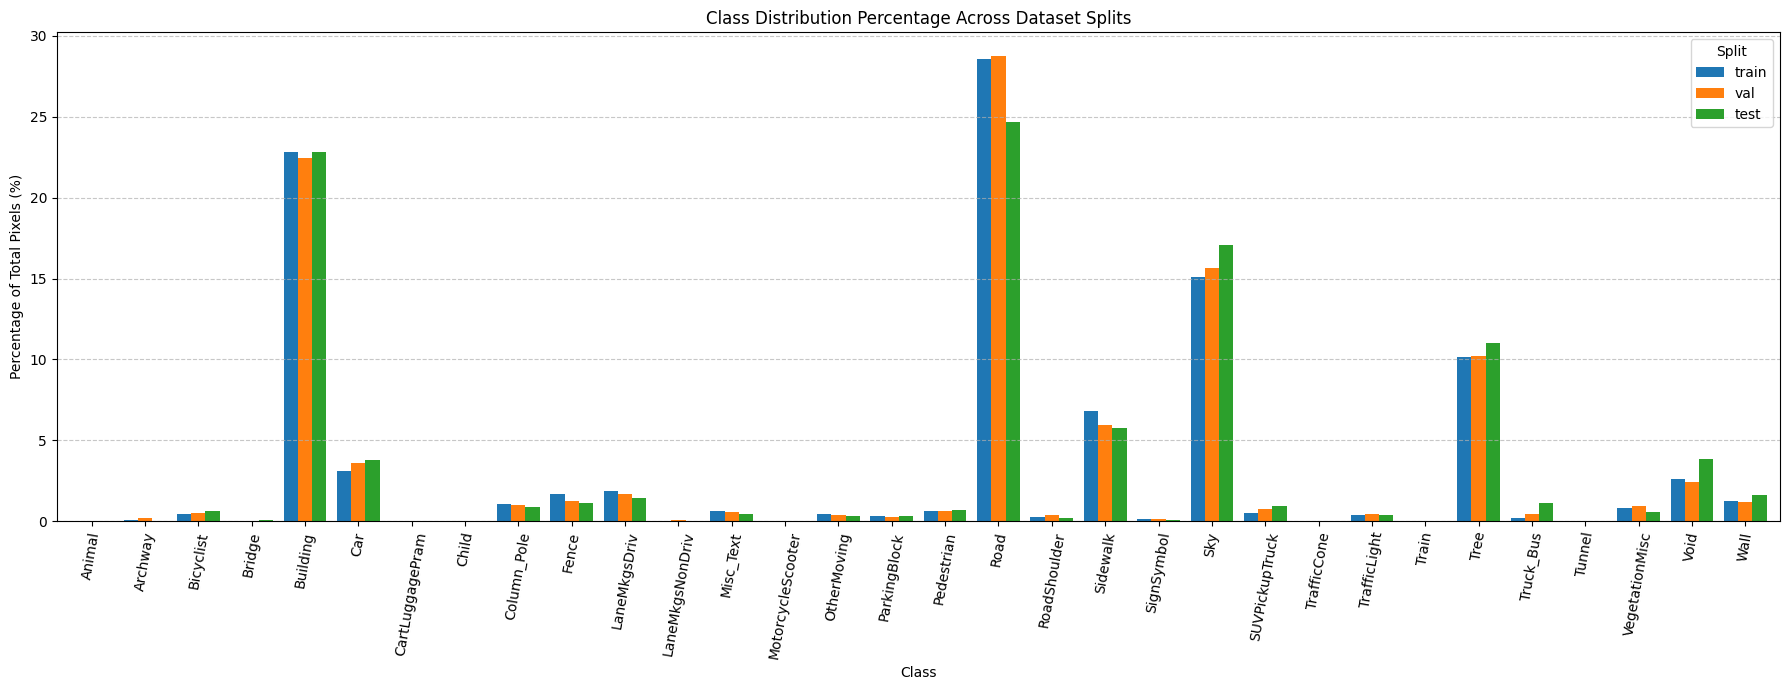


--- Finished Evaluation ---


In [30]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import time
import csv
from collections import defaultdict
import pandas as pd 

# === Configuration ===
DATASET_BASE_PATH = "/kaggle/input/camvid" 
CAMVID_SUBDIR = "CamVid"
CLASS_DICT_FILENAME = "class_dict.csv"

# Model & Training Hyperparameters
IMG_HEIGHT = 720
IMG_WIDTH = 960
NUM_CLASSES = 32
IGNORE_CLASS_ID = 30

# Checkpoint & Output
CHECKPOINT_DIR = "./fast_scnn_checkpoints"
CHECKPOINT_FILENAME = "best_model.keras" # best model
PLOT_FILENAME = "training_history.png" 
STATS_PLOT_FILENAME = "dataset_class_distribution.png"

color_int_to_id_map = {}
id_to_name_map = {}

def load_class_dict_for_mapping(csv_path):
    global color_int_to_id_map, id_to_name_map
    color_int_to_id_map = {}
    id_to_name_map = {}
    required_ids = set(range(NUM_CLASSES))
    found_ids = set()
    try:
        with open(csv_path, mode='r') as infile:
            reader = csv.reader(infile)
            header = next(reader)
            current_id = 0
            for row in reader:
                if len(row) == 4:
                    name = row[0].strip(); color_int = tuple(int(c) for c in row[1:4])
                    if current_id < NUM_CLASSES:
                        if color_int not in color_int_to_id_map:
                            color_int_to_id_map[color_int] = current_id
                            id_to_name_map[current_id] = name
                            found_ids.add(current_id)
                        current_id += 1
        missing_ids = required_ids - found_ids
        if missing_ids: print(f"Warning: Missing class IDs: {sorted(list(missing_ids))}")
        print(f"Loaded {len(color_int_to_id_map)} class color mappings.")
        return True
    except Exception as e: print(f"Error loading class dict: {e}"); return False


def rgb_to_id_mask_py(rgb_mask_np):
    id_mask = np.zeros((rgb_mask_np.shape[0], rgb_mask_np.shape[1]), dtype=np.int32)
    default_id = IGNORE_CLASS_ID if IGNORE_CLASS_ID is not None else 0
    id_mask.fill(default_id) 
    for color_tuple, class_id in color_int_to_id_map.items():
        matches = np.all(rgb_mask_np == color_tuple, axis=-1)
        id_mask[matches] = class_id
    return id_mask[:, :, np.newaxis]

@tf.function
def rgb_to_id_mask_tf(rgb_mask):
    id_mask = tf.py_function(func=rgb_to_id_mask_py, inp=[rgb_mask], Tout=tf.int32)
    id_mask.set_shape([None, None, 1])
    return id_mask

@tf.function
def load_image_and_mask(image_path, mask_path):
    image = tf.io.read_file(image_path); image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH], method='bilinear')
    image = tf.cast(image, tf.float32) / 255.0
    mask = tf.io.read_file(mask_path); mask = tf.image.decode_png(mask, channels=3)
    mask = tf.image.resize(mask, [IMG_HEIGHT, IMG_WIDTH], method='nearest')
    mask = tf.cast(mask, tf.uint8)
    mask_id = rgb_to_id_mask_tf(mask)
    mask_id = tf.squeeze(mask_id, axis=-1)
    return image, mask_id

# Dataset Creation
def create_tf_dataset_for_split(split_name, batch_size, shuffle=False):
    """Creates a TensorFlow dataset for a given split ('train', 'val', 'test')."""
    camvid_dir = os.path.join(DATASET_BASE_PATH, CAMVID_SUBDIR)
    image_dir = os.path.join(camvid_dir, split_name)
    mask_dir = os.path.join(camvid_dir, f"{split_name}_labels")

    if not os.path.isdir(image_dir) or not os.path.isdir(mask_dir):
         print(f"Warning: Directory missing for split '{split_name}'. Searched: {image_dir}, {mask_dir}")
         return None 

    image_files = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.png')])
    mask_files = []
    valid_image_files = []

    for img_path in image_files:
        img_filename = os.path.basename(img_path)
        base_name = img_filename.replace('.png', '')
        mask_filename = base_name + "_L.png"
        mask_path = os.path.join(mask_dir, mask_filename)
        if os.path.exists(mask_path):
            mask_files.append(mask_path)
            valid_image_files.append(img_path)

    if not valid_image_files:
        print(f"Warning: No valid image/mask pairs found for split '{split_name}'.")
        return None

    print(f"Found {len(valid_image_files)} image/mask pairs for split '{split_name}'.")

    dataset = tf.data.Dataset.from_tensor_slices((valid_image_files, mask_files))
    dataset = dataset.map(load_image_and_mask, num_parallel_calls=tf.data.AUTOTUNE)

    # Cache after mapping
    # dataset = dataset.cache()

    if shuffle:
        buffer_size = min(len(valid_image_files), BUFFER_SIZE)
        dataset = dataset.shuffle(buffer_size)

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

    return dataset


def calculate_split_statistics(dataset, num_classes):
    """Calculates pixel counts per class for a given tf.data.Dataset."""
    if dataset is None:
        return None, 0

    print(f"Calculating statistics for dataset...")
    pixel_counts = tf.zeros(num_classes, dtype=tf.int64)
    total_pixels = 0
    start_time = time.time()

    for i, (images, masks) in enumerate(dataset):
        batch_pixels = tf.size(masks, out_type=tf.int64)
        total_pixels += batch_pixels

        masks_flat = tf.reshape(masks, [-1])

        batch_counts = tf.math.bincount(tf.cast(masks_flat, tf.int32),
                                        minlength=num_classes,
                                        maxlength=num_classes,
                                        dtype=tf.int64)
        pixel_counts += batch_counts
        if (i + 1) % 5 == 0:
             print(f"  Processed batch {i+1}...")

    end_time = time.time()
    print(f"Statistics calculation took {end_time - start_time:.2f} seconds.")
    return pixel_counts.numpy(), total_pixels 


def plot_class_distribution_comparison(stats_dict, id_to_name_map, filename="stats_comparison.png"):
    """Plots a grouped bar chart comparing class distributions."""
    splits = list(stats_dict.keys())
    if not splits:
        print("No statistics data to plot.")
        return

    reference_ids = sorted(id_to_name_map.keys())
    class_names = [id_to_name_map.get(i, f"ID_{i}") for i in reference_ids]

    percentages = {}
    for split in splits:
        counts, total = stats_dict[split]
        split_percentages = (counts / total * 100) if total > 0 else np.zeros_like(counts)
        percentages[split] = [split_percentages[i] if i < len(split_percentages) else 0 for i in reference_ids]


    df = pd.DataFrame(percentages, index=class_names).astype(float) 

    # Plotting
    ax = df.plot(kind='bar', figsize=(18, 7), width=0.8) 

    plt.title('Class Distribution Percentage Across Dataset Splits')
    plt.ylabel('Percentage of Total Pixels (%)')
    plt.xlabel('Class')
    plt.xticks(rotation=80) 
    plt.legend(title='Split')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()

    try:
        plt.savefig(filename)
        print(f"Class distribution plot saved to {filename}")
    except Exception as e:
        print(f"Error saving plot: {e}")
    plt.show()


# Main Evaluation
if __name__ == "__main__":
    print("--- Starting Fast-SCNN Evaluation and Statistics ---")

    # Load Class Dictionary
    camvid_dir = os.path.join(DATASET_BASE_PATH, CAMVID_SUBDIR)
    class_dict_path = os.path.join(camvid_dir, CLASS_DICT_FILENAME)
    if not load_class_dict_for_mapping(class_dict_path):
        exit("Failed to load class dictionary. Exiting.")

    # Load the Best Saved Model
    print("\nLoading best saved model...")
    checkpoint_filepath = os.path.join(CHECKPOINT_DIR, CHECKPOINT_FILENAME)
    if not os.path.exists(checkpoint_filepath):
        exit(f"Error: Checkpoint file not found at {checkpoint_filepath}. Please train the model first.")

    try:
        custom_objects = {
            'MeanIoU': MeanIoU,
            'DiceCoefficient': DiceCoefficient,
        }
        model = tf.keras.models.load_model(checkpoint_filepath, custom_objects=custom_objects)
        print("Model loaded successfully.")
        model.summary()
    except Exception as e:
        exit(f"Error loading model: {e}")

    # Create Test Dataset
    print("\nCreating test dataset...")
    EVAL_BATCH_SIZE = BATCH_SIZE
    test_dataset = create_tf_dataset_for_split('test', EVAL_BATCH_SIZE, shuffle=False)

    if test_dataset is None:
        print("Could not create test dataset. Skipping evaluation.")
    else:
        # Evaluate on Test Set
        print("\n--- Evaluating Model on Test Set ---")
        start_time = time.time()
        test_results = model.evaluate(test_dataset, verbose=1)
        eval_time = time.time() - start_time
        print(f"--- Test Evaluation Finished in {eval_time:.2f} seconds ---")

        print("\nTest Set Results:")
        if len(test_results) >= 4:
             print(f"  Loss:             {test_results[0]:.4f}")
             print(f"  Accuracy:         {test_results[1]:.4f}")
             print(f"  Mean IoU:         {test_results[2]:.4f}")
             print(f"  Dice Coefficient: {test_results[3]:.4f}")
        else:
             print(f"  Raw Results: {test_results}") 

    # Calculate Statistics for All Splits
    print("\n--- Calculating Pixel Statistics for Splits ---")
    all_stats = {}
    STATS_BATCH_SIZE = 32 
    train_stats_dataset = create_tf_dataset_for_split('train', STATS_BATCH_SIZE, shuffle=False)
    val_stats_dataset = create_tf_dataset_for_split('val', STATS_BATCH_SIZE, shuffle=False)
    test_stats_dataset = create_tf_dataset_for_split('test', STATS_BATCH_SIZE, shuffle=False)

    print("\nCalculating Train Stats...")
    train_counts, train_total = calculate_split_statistics(train_stats_dataset, NUM_CLASSES)
    if train_counts is not None: all_stats['train'] = (train_counts, train_total)

    print("\nCalculating Validation Stats...")
    val_counts, val_total = calculate_split_statistics(val_stats_dataset, NUM_CLASSES)
    if val_counts is not None: all_stats['val'] = (val_counts, val_total)

    print("\nCalculating Test Stats...")
    test_counts, test_total = calculate_split_statistics(test_stats_dataset, NUM_CLASSES)
    if test_counts is not None: all_stats['test'] = (test_counts, test_total)

    # Plot Statistics Comparison
    print("\n--- Plotting Class Distribution Comparison ---")
    if all_stats:
        plot_class_distribution_comparison(all_stats, id_to_name_map, filename=STATS_PLOT_FILENAME)
    else:
        print("No statistics were calculated, skipping plot.")

    print("\n--- Finished Evaluation ---")

--- Starting Test Set Visualization ---
Loaded 32 class ID-to-color mappings.

Loading trained model...

Finding test set files...
Found 232 test image/mask pairs.

Generating predictions for 10 random test samples...
  Processing sample 1/10: 0001TP_008190.png


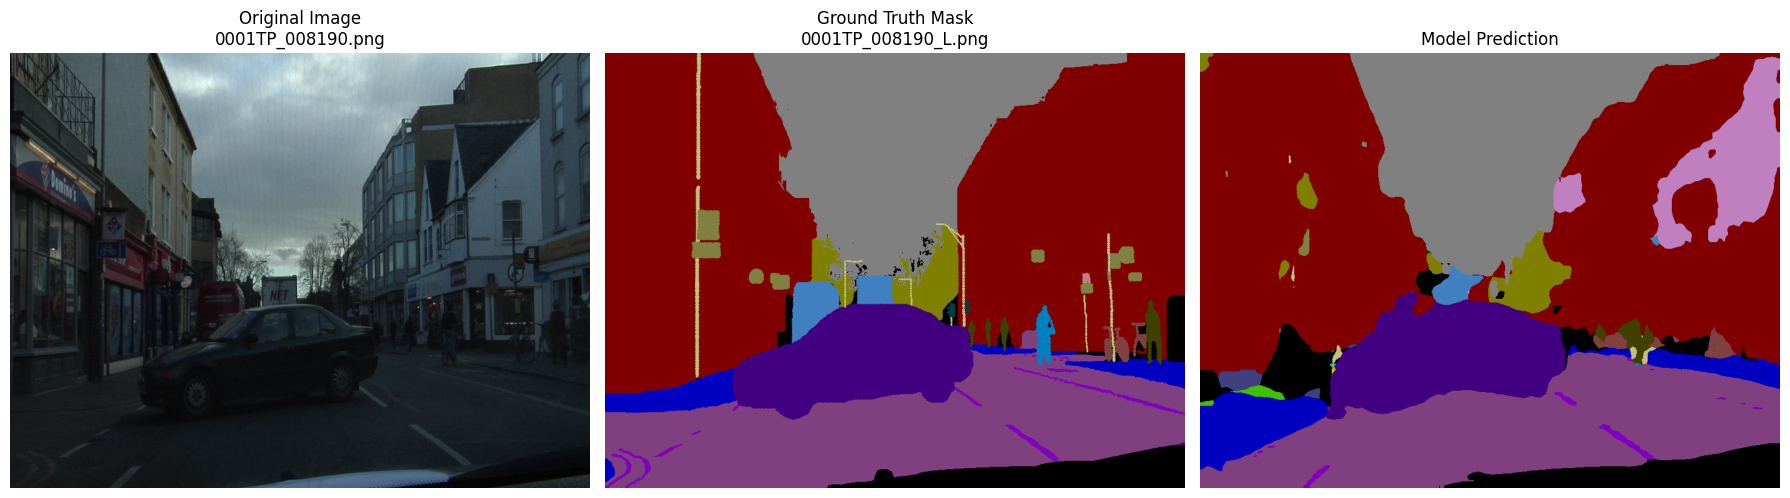

  Processing sample 2/10: 0016E5_08029.png


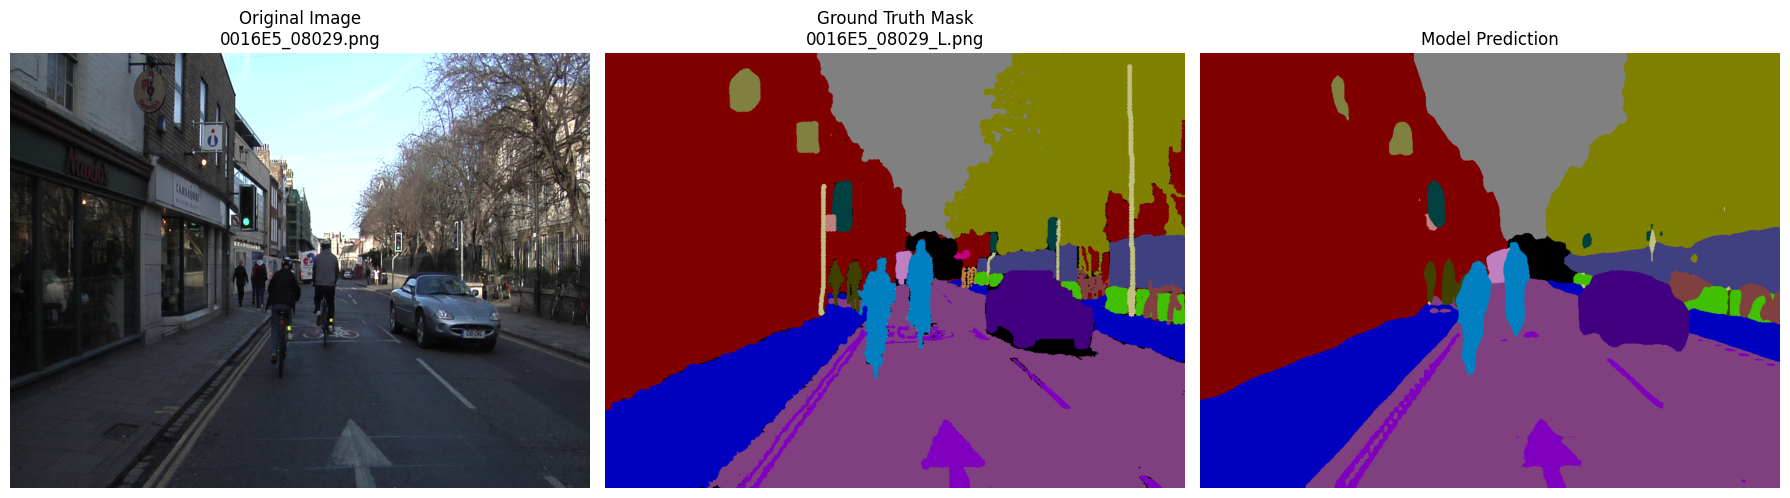

  Processing sample 3/10: 0016E5_08580.png


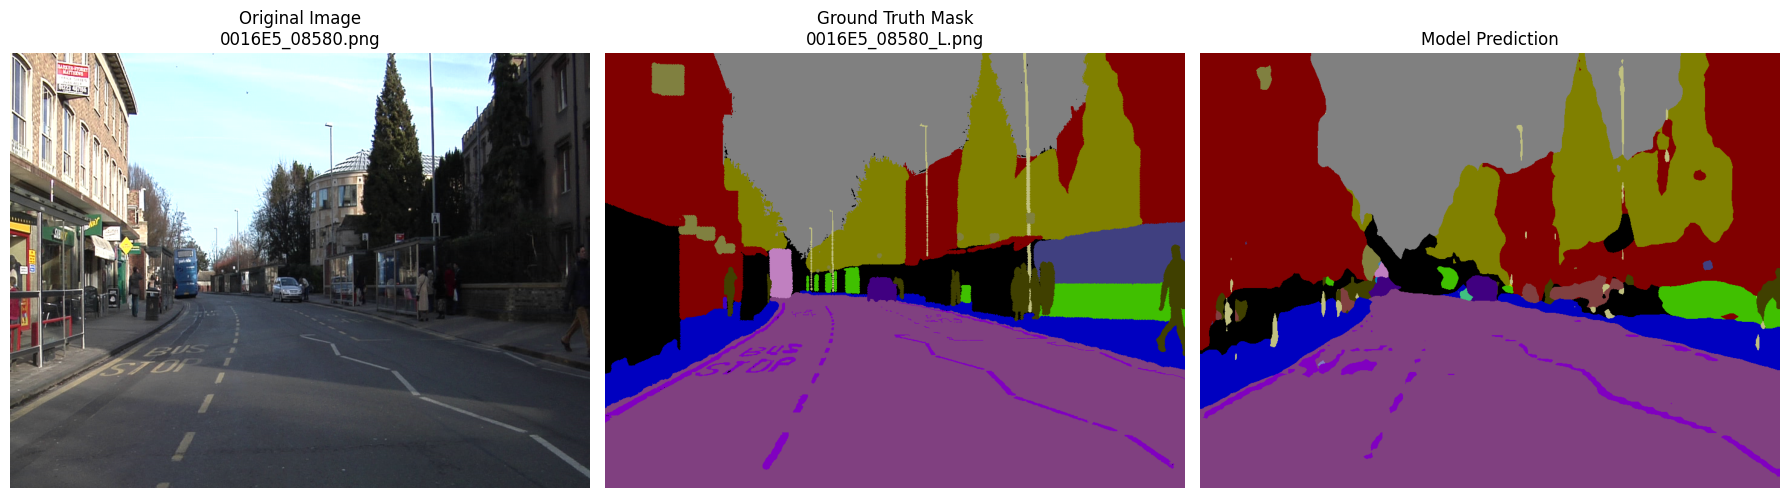

  Processing sample 4/10: Seq05VD_f01140.png


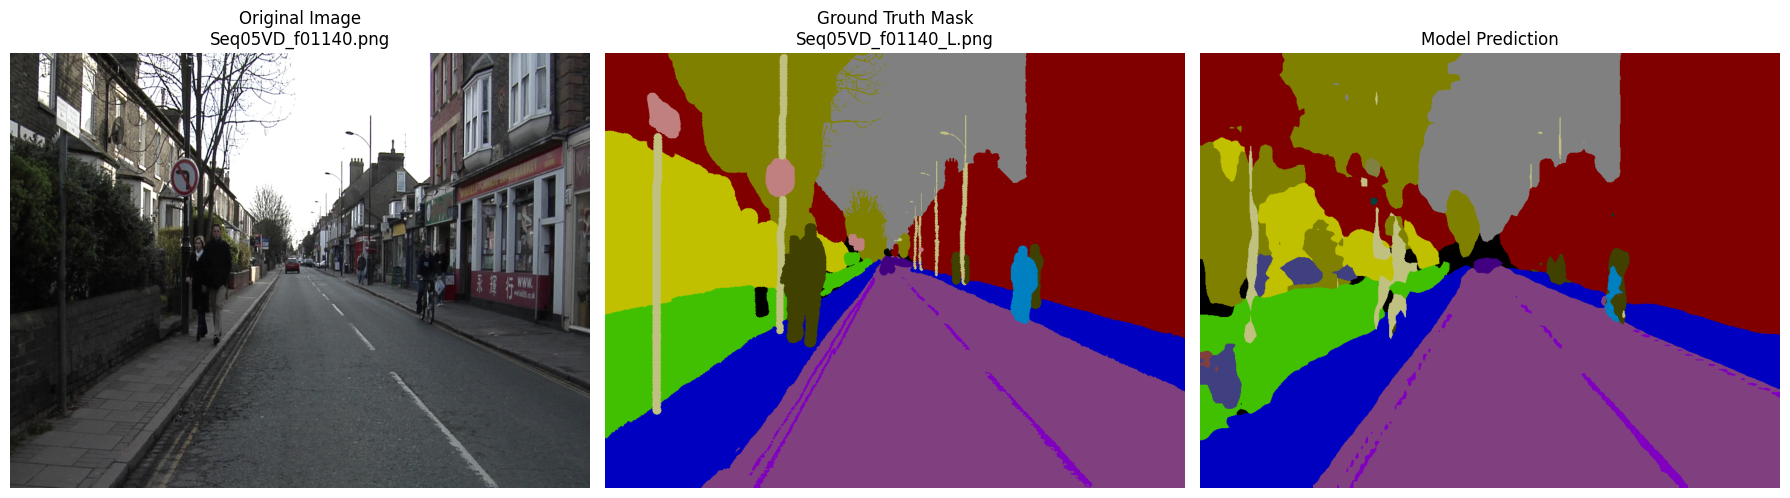

  Processing sample 5/10: Seq05VD_f02670.png


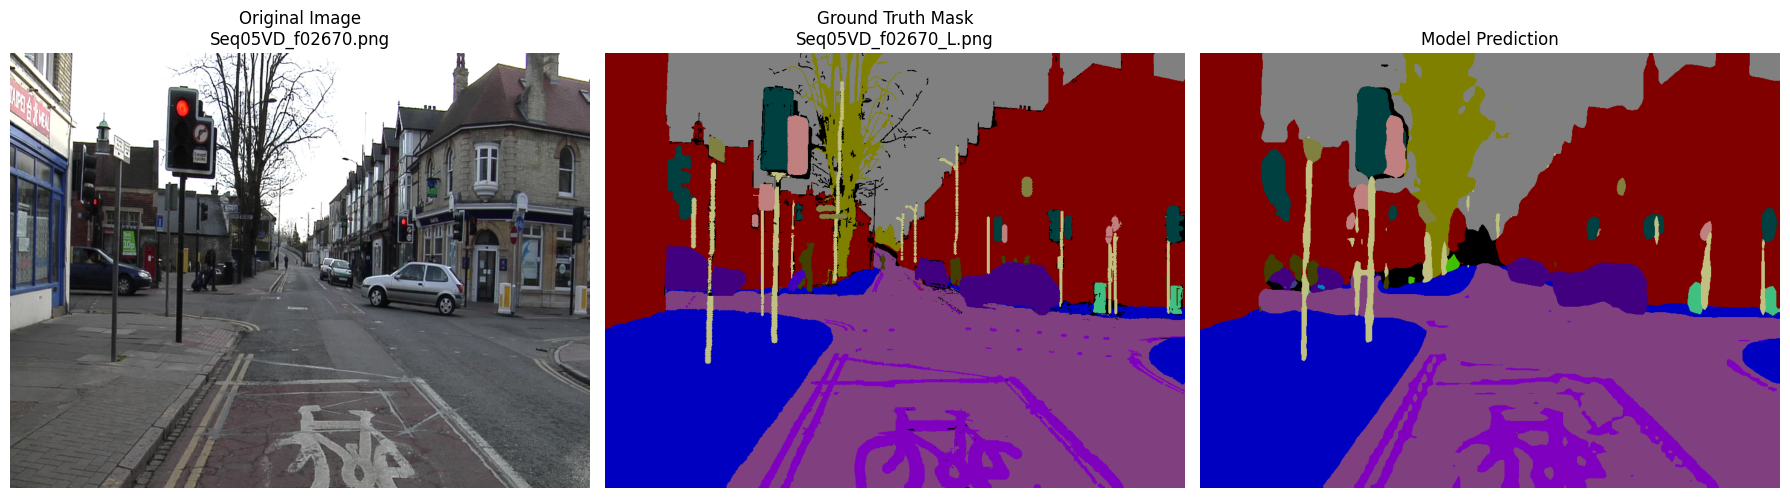

  Processing sample 6/10: 0016E5_05700.png


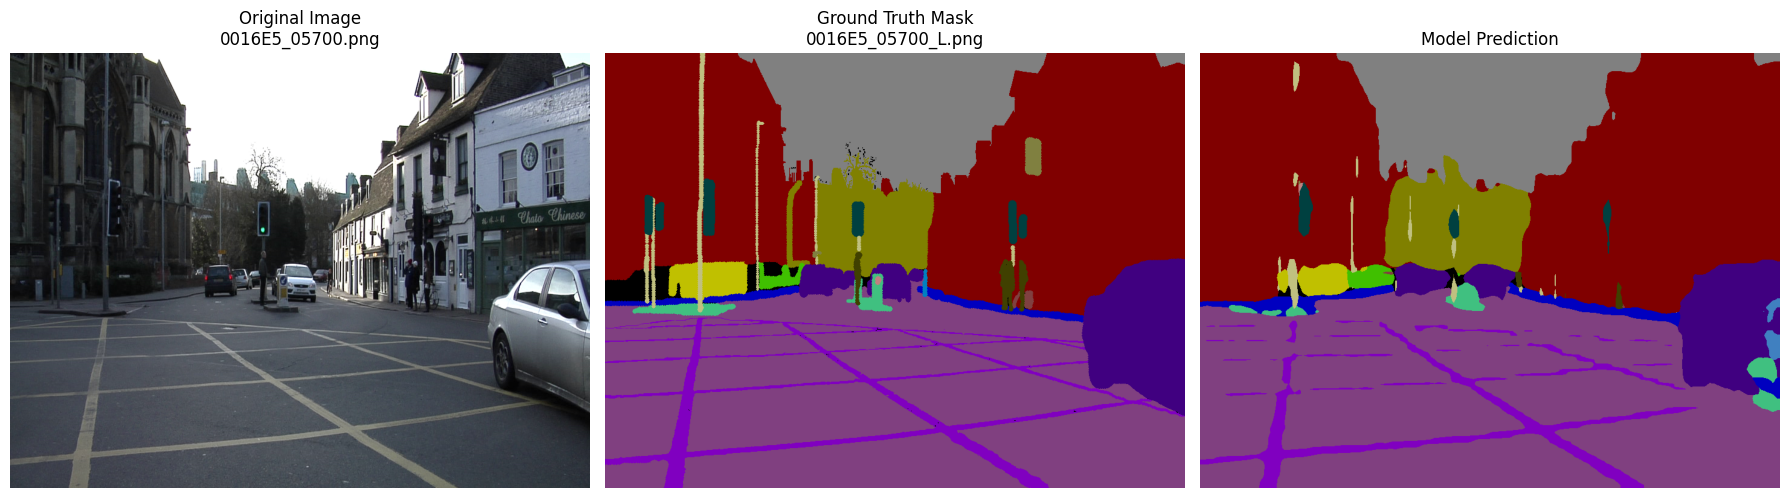

  Processing sample 7/10: 0016E5_05040.png


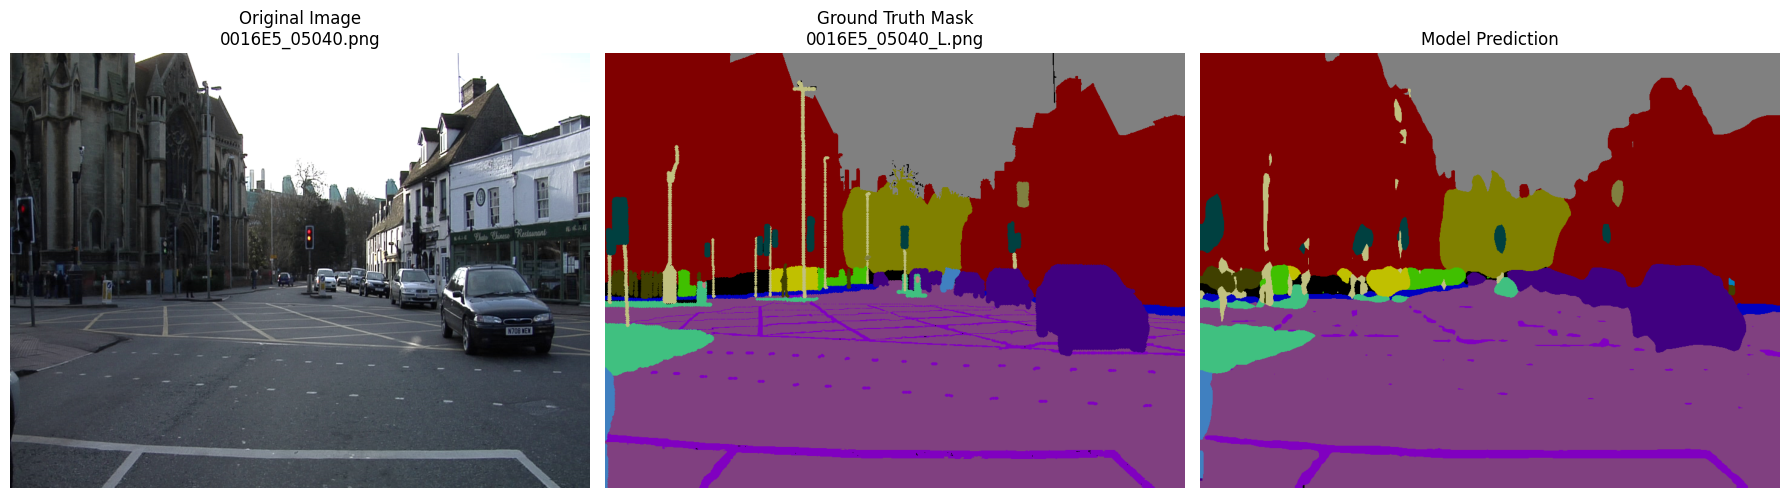

  Processing sample 8/10: 0016E5_06540.png


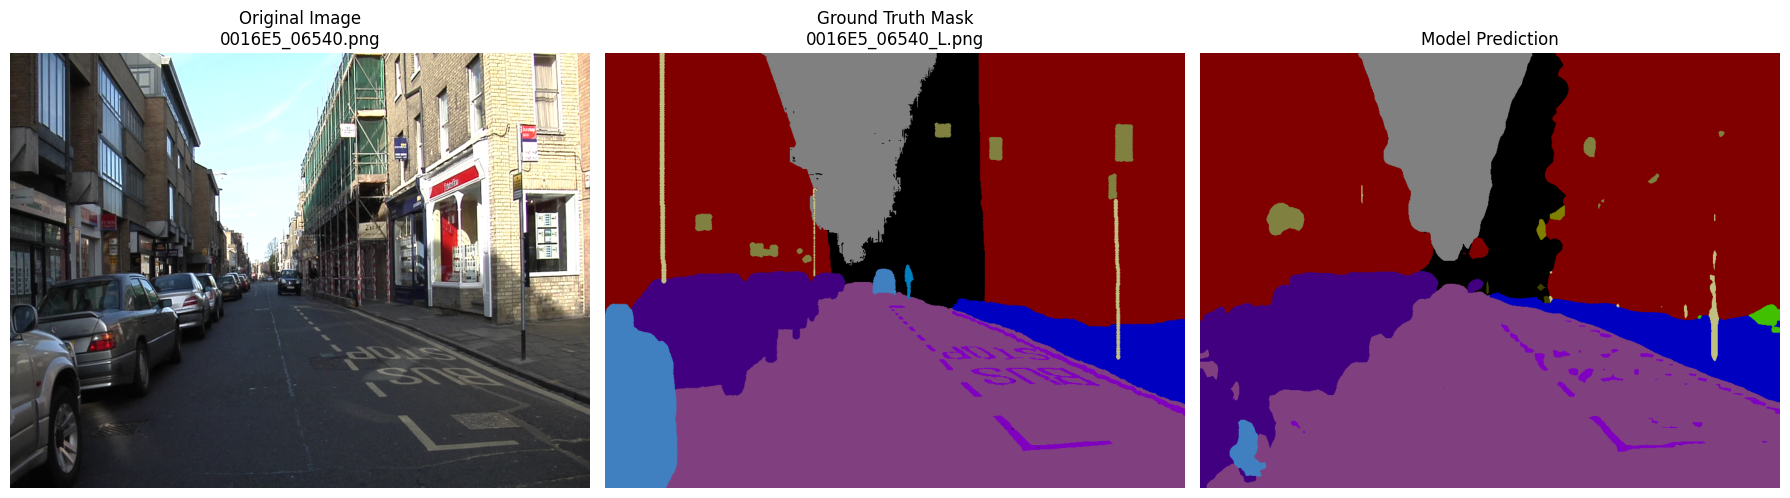

  Processing sample 9/10: 0001TP_008610.png


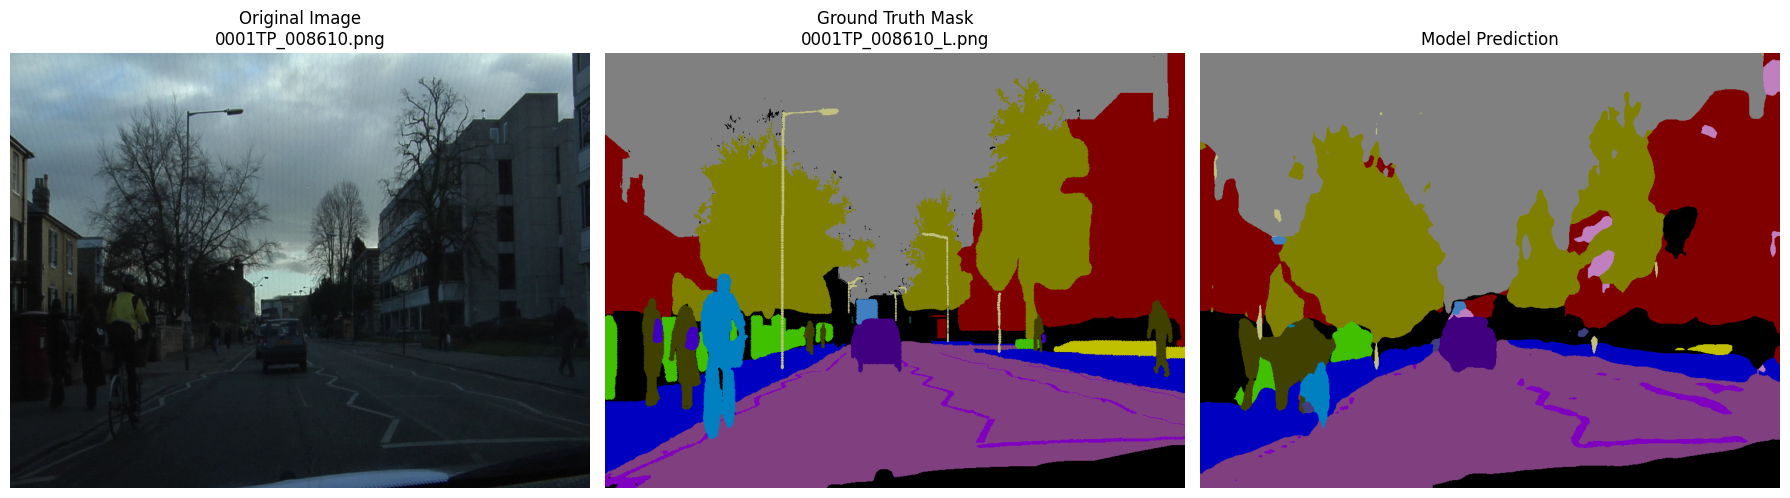

  Processing sample 10/10: 0016E5_07969.png


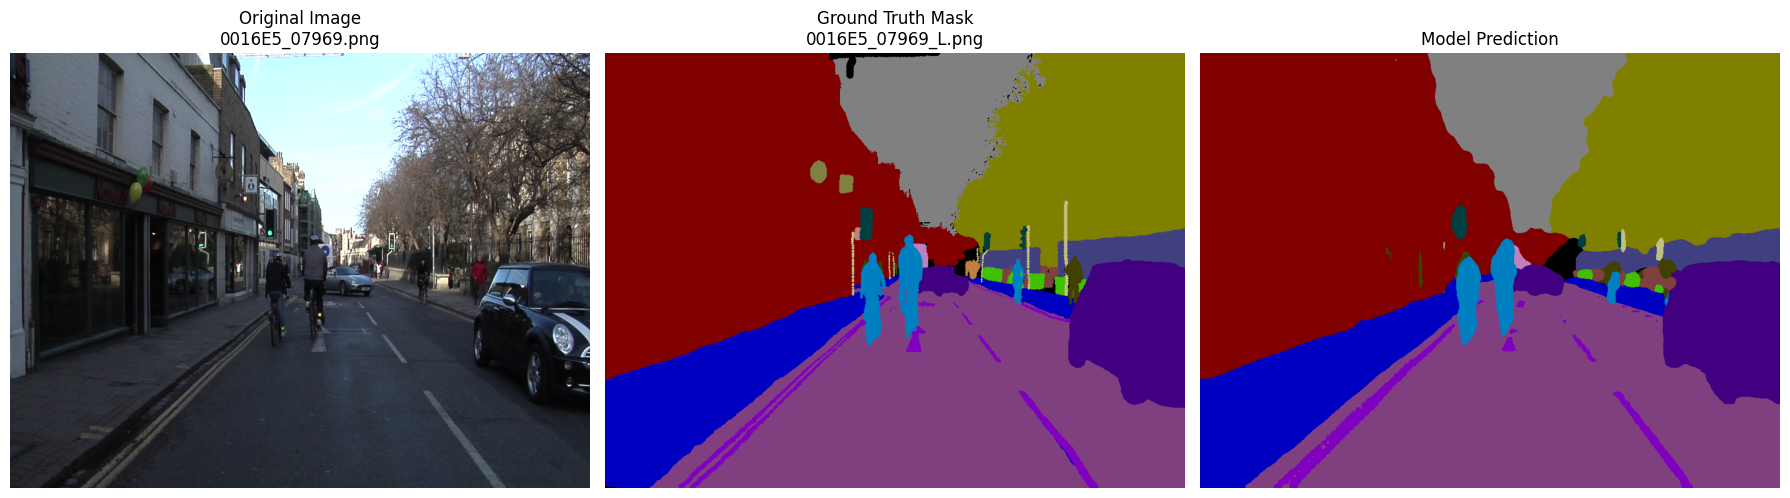


--- Visualization Finished ---


In [31]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random
import csv
from PIL import Image 

# Configuration 
DATASET_BASE_PATH = "/kaggle/input/camvid" 
CAMVID_SUBDIR = "CamVid"
CLASS_DICT_FILENAME = "class_dict.csv"

# Model & Image Parameters
IMG_HEIGHT = 720 
IMG_WIDTH = 960  
NUM_CLASSES = 32 

# Checkpoint 
CHECKPOINT_DIR = "./fast_scnn_checkpoints"
CHECKPOINT_FILENAME = "best_model.keras"

NUM_SAMPLES_TO_SHOW = 10


id_to_color_int_map = {} # Map ID -> (R, G, B) tuple (0-255)
id_to_name_map = {}      # Map ID -> Class Name

def load_class_dict_for_viz(csv_path):
    """Loads class names and ID -> color mapping."""
    global id_to_color_int_map, id_to_name_map
    id_to_color_int_map = {}
    id_to_name_map = {}
    try:
        with open(csv_path, mode='r') as infile:
            reader = csv.reader(infile)
            header = next(reader) 
            current_id = 0
            for row in reader:
                if len(row) == 4:
                    name = row[0].strip()
                    try:
                        color_int = tuple(int(c) for c in row[1:4])
                        if current_id < NUM_CLASSES:
                             id_to_color_int_map[current_id] = color_int
                             id_to_name_map[current_id] = name
                        current_id += 1
                    except ValueError: pass 
        print(f"Loaded {len(id_to_color_int_map)} class ID-to-color mappings.")
        if len(id_to_color_int_map) != NUM_CLASSES:
             print(f"Warning: Loaded {len(id_to_color_int_map)} colors, but expected {NUM_CLASSES}.")
        return True
    except Exception as e:
        print(f"Error loading class dict for viz: {e}")
        return False

def create_colored_mask_from_ids(id_mask_np, id_to_color_map):
    """Creates an RGB mask image (HxWx3 NumPy uint8) from an ID mask (HxW NumPy int)."""
    h, w = id_mask_np.shape
    rgb_mask = np.zeros((h, w, 3), dtype=np.uint8)

    default_color = (0, 0, 0)

    for class_id, color in id_to_color_map.items():
        rgb_mask[id_mask_np == class_id] = color

    present_ids = np.unique(id_mask_np)
    mapped_ids = set(id_to_color_map.keys())
    unmapped_ids = set(present_ids) - mapped_ids
    if unmapped_ids:
        for uid in unmapped_ids:
             rgb_mask[id_mask_np == uid] = default_color

    return rgb_mask


if __name__ == "__main__":
    print("--- Starting Test Set Visualization ---")

    # Load Class Dictionary for Colors 
    camvid_dir = os.path.join(DATASET_BASE_PATH, CAMVID_SUBDIR)
    class_dict_path = os.path.join(camvid_dir, CLASS_DICT_FILENAME)
    if not load_class_dict_for_viz(class_dict_path):
        exit("Failed to load class dictionary for visualization. Exiting.")
    if not id_to_color_int_map:
         exit("ID-to-Color map is empty. Exiting.")

    # Load the Trained Model 
    print("\nLoading trained model...")
    checkpoint_filepath = os.path.join(CHECKPOINT_DIR, CHECKPOINT_FILENAME)
    if not os.path.exists(checkpoint_filepath):
        exit(f"Error: Model checkpoint file not found at {checkpoint_filepath}.")

    try:
        custom_objects = {
            'MeanIoU': MeanIoU,
            'DiceCoefficient': DiceCoefficient,
            'DepthwiseSeparableConv': DepthwiseSeparableConv,
            'InvertedResidual': InvertedResidual,
            'PyramidPoolingModule': PyramidPoolingModule,
            'FeatureFusionModule': FeatureFusionModule
        }
        model = tf.keras.models.load_model(checkpoint_filepath, custom_objects=custom_objects)
        print("Model loaded successfully.")
    except Exception as e:
        exit(f"Error loading model: {e}")

    # Get Test Set Files 
    print("\nFinding test set files...")
    test_image_dir = os.path.join(camvid_dir, 'test')
    test_mask_dir = os.path.join(camvid_dir, 'test_labels')

    try:
        test_image_files = sorted([os.path.join(test_image_dir, f) for f in os.listdir(test_image_dir) if f.endswith('.png')])
        test_mask_files_map = {os.path.basename(f).replace('_L.png', '.png'): os.path.join(test_mask_dir, f)
                               for f in os.listdir(test_mask_dir) if f.endswith('_L.png')}

        test_pairs = []
        for img_path in test_image_files:
            img_filename = os.path.basename(img_path)
            if img_filename in test_mask_files_map:
                test_pairs.append((img_path, test_mask_files_map[img_filename]))

        if not test_pairs:
            exit("Error: No matching image/mask pairs found in the test set.")

        print(f"Found {len(test_pairs)} test image/mask pairs.")

    except FileNotFoundError:
         exit(f"Error: Test directories not found. Searched: {test_image_dir}, {test_mask_dir}")
    except Exception as e:
         exit(f"Error listing test files: {e}")


    # Select Random Samples
    num_available = len(test_pairs)
    num_to_show = min(NUM_SAMPLES_TO_SHOW, num_available)
    if num_to_show < NUM_SAMPLES_TO_SHOW:
        print(f"Warning: Only {num_available} test samples available, showing {num_to_show}.")

    random_indices = random.sample(range(num_available), num_to_show)
    selected_pairs = [test_pairs[i] for i in random_indices]

    # Predict and Visualize
    print(f"\nGenerating predictions for {num_to_show} random test samples...")

    for i, (img_path, mask_path) in enumerate(selected_pairs):
        print(f"  Processing sample {i+1}/{num_to_show}: {os.path.basename(img_path)}")
        try:
            # Load Original Image and GT Mask 
            original_img_pil = Image.open(img_path).convert('RGB')
            gt_mask_pil = Image.open(mask_path).convert('RGB') 

            # Preprocess Image for Model Input
            image_tf = tf.io.read_file(img_path)
            image_tf = tf.image.decode_png(image_tf, channels=3)
            image_tf = tf.image.resize(image_tf, [IMG_HEIGHT, IMG_WIDTH], method='bilinear')
            image_tf = tf.cast(image_tf, tf.float32) / 255.0
            image_tf_batch = tf.expand_dims(image_tf, axis=0) # Add batch dimension

            # Predict
            pred_logits = model.predict(image_tf_batch, verbose=0) # Get logits [1, H, W, N_CLASSES]
            pred_ids_tf = tf.argmax(pred_logits, axis=-1) # Get class IDs [1, H, W]
            pred_ids_np = tf.squeeze(pred_ids_tf, axis=0).numpy().astype(np.int32) # Remove batch dim -> [H, W]

            # Convert Predicted IDs to Colored Mask 
            pred_mask_rgb_np = create_colored_mask_from_ids(pred_ids_np, id_to_color_int_map)

            # Plotting
            plt.figure(figsize=(18, 6)) 

            plt.subplot(1, 3, 1)
            plt.imshow(original_img_pil)
            plt.title(f"Original Image\n{os.path.basename(img_path)}")
            plt.axis('off')

            plt.subplot(1, 3, 2)
            plt.imshow(gt_mask_pil) 
            plt.title(f"Ground Truth Mask\n{os.path.basename(mask_path)}")
            plt.axis('off')

            plt.subplot(1, 3, 3)
            plt.imshow(pred_mask_rgb_np) 
            plt.title("Model Prediction")
            plt.axis('off')

            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"  Error processing sample {os.path.basename(img_path)}: {e}")

    print("\n--- Visualization Finished ---")